In [1]:
import os
from datetime import datetime, date
from sklearn import utils
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

#import torch
#import torch.nn as nn
#import torch.nn.functional as fn
#import torch.optim as optim

#device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
#plt.style.use('ggplot')

### 0. Utils

### Preprocessor
---------------------

In [5]:
class Preprocessor:
    def _fit_transform(self, raw):
        result = raw.copy()

        result = self._n_comment_to_float(result)
        result = self._str_to_datetype(result)
        result = self._add_n_hashtag(result)
        
        self.non_numeric = ['channel', 'title', 'genre', 'description', 'date', 'sign_in']
        result = self._merge(result, self.non_numeric)
        
        features = ['cumul_view', 'n_dislike', 'n_like', 'n_comment', 'video_n_view', 'cumul_subs']
        new_name = ['view_diff', 'dislike_diff', 'like_diff', 'comment_diff', 'video_n_view_diff', 'sub_diff']
        result = self._add_diff(result, features, new_name)
        
        result = self._add_no_upload_interval(result)
        result = self._remove_nan(result)
        self._one_hot(result)

        return result
        
        
        
    #FEATRUES TO ADD & MODIFY
    ####################################################################     
    def _n_comment_to_float(self,result):
        idx1 = result['n_comment'] == '댓글 사용 중지'
        idx2 = result.n_comment.isna()
        idx = idx1|idx2
        result['n_comment'].loc[idx] = result['n_comment'].loc[idx].apply(lambda x: 0)
        result['n_comment'] = result['n_comment'].astype(float)
        return result
        
    
    def _str_to_datetype(self,result):
        if pd.api.types.is_datetime64_ns_dtype(result['date']):
            pass
        else:
            result['date'] = pd.to_datetime(result['date'])
        return result
    
    
    def _add_n_hashtag(self,result):
        result['n_hashtage'] = 0
        idx = result['description'].notnull()
        result.loc[idx, 'n_hashtage'] = result.loc[idx, 'description'].apply(lambda x: len(x.split('#'))-1)
        return result
        
    
    @staticmethod
    def _get_to_merge(data, numeric, non_numeric):
        data = data.reset_index(drop=True)
        num_to_add = data.title.shape[0] - data.title.isna().sum()
        data = pd.concat((data.loc[0,non_numeric], data[numeric].mean()))
        data['video_num'] = num_to_add
        return data
    def _merge(self, result, non_numeric):
        #operate both merge and creating video_num featrue simultaneously.
        numeric = [col for col in result.columns.tolist() if col not in non_numeric]
        return result.groupby(['channel', 'date']).apply(lambda x: self._get_to_merge(x, numeric, non_numeric)).reset_index(drop=True)
    
    
    @staticmethod
    def _get_diff(result, feature, new_name):
        result = result.reset_index(drop=True)
        result[new_name] = (result[feature] - result[feature].shift())
        return result
    def _add_diff(self, result, feature, new_name):
        result = result.groupby('channel').apply(lambda x: self._get_diff(x, feature, new_name)).reset_index(drop=True)
        result[new_name] = result[new_name].fillna(0)
        return result
    
    
    @staticmethod
    def _get_no_upload_interval(result):
        result = result.reset_index(drop=True)
        upload_idx = result[result['video_num'] != 0].index.tolist()
        temp = [0 for i in range(result.shape[0])]
        for i in range(len(upload_idx)):
            if i == len(upload_idx)-1:
                former = upload_idx[i]
                temp[former+1:] = [i+1 for i in range(len(temp[former+1:]))]
            else:
                former, latter = upload_idx[i], upload_idx[i+1]
                temp[former+1:latter] = [i+1 for i in range(len(temp[former+1:latter]))]
        result['no_upload_interval'] = temp
        return result
    def _add_no_upload_interval(self,result):
        return result.groupby('channel').apply(lambda x: self._get_no_upload_interval(x)).reset_index(drop=True)
    
    
    def _remove_nan(self, result):
        numeric = [col for col in result.columns.tolist() if col not in self.non_numeric]
        result.loc[:, numeric] = result.loc[:,numeric].fillna(0)
        return result
    
    
    def _one_hot(self, data):
        data.loc[:,'genre'] = data.genre.fillna('etc')
        genre = data.genre.unique().tolist()
        for i, name in enumerate(genre):
            data.genre[data.genre==name] = data.genre[data.genre==name].apply(lambda x: i)
            
        one_hot = pd.get_dummies(data.genre.unique().tolist())
        data['one_hot'] = data.genre
        for i in range(len(one_hot)):
            data.loc[data.genre==i,'one_hot'] = data.loc[data.genre==i, 'genre'].apply(lambda x: one_hot[i].values)
    ####################################################################
    
    
    
    #CREATE SEQUENTIAL DATA
    ####################################################################
    def _extract_at_least_filter(self, result, filter_size):
        #fillter_size 이상인 채널 추출하기
        alive_idx = result['channel'].value_counts() >= filter_size
        alive_array = alive_idx[alive_idx==True].index
        return result[result['channel'].isin(alive_array)].reset_index(drop=True)
    
    
    @staticmethod
    def _to_sequential(result, filter_size, target_size, stride, features, target_features):
        result = result.reset_index(drop=True)
        idx_list = result.index.tolist()
        
        train, target = [],[]
        for i in range((len(idx_list)-filter_size-target_size)//stride +1):
            train_idx = idx_list[i*stride : i*stride + filter_size]
            target_idx = idx_list[i*stride + filter_size : i*stride + filter_size + target_size]
            train_temp = result.loc[train_idx,:].values.reshape(1,-1)
            target_temp = result.loc[target_idx,target_features].values.reshape(1,-1)
            
            train = train_temp.copy() if i == 0 else np.vstack([train, train_temp])
            target = target_temp.copy() if i == 0 else np.vstack([target, target_temp])
            
        train = pd.DataFrame(train, columns = result.columns.tolist()*filter_size)
        target = pd.DataFrame(target, columns = target_features*target_size)
        return train[features], target
    def _create_sequential_data(self, result, filter_size=7, target_size=1, stride=1, features=None, target_features=None):
        #remove channels with few information with respect to filter_size and target_size to extract
        result = self._extract_at_least_filter(result, filter_size + target_size)
        
        #features: features to drop fromf X (features)
        #target_features: features to extract from Y (targets)
        if features is None:
            features = ['date', 'genre','title', 'channel', 'description',	'sign_in', 'current_cumul_view', 'current_n_video', 'current_cumul_subs']
        if target_features is None:
            target_features = ['sub_diff']
        
        #return train, target set wrt groups
        result = result.groupby('channel').apply(lambda x: self._to_sequential(x, filter_size, target_size, stride, features, target_features)).reset_index(drop=True)
        return self._combine(result)
    
    
    def _combine(self, result):
        temp0, temp1 = [], []
        for i in range(len(result)):
            temp0.append(result[i][0])
            temp1.append(result[i][1])
        temp0 = pd.concat(temp0)
        temp1 = pd.concat(temp1)
        return (temp0, temp1)
    ####################################################################


    
    #SCALE
    ####################################################################
    def scale(self, data, return_original_scale=True):
        original_scale = pd.concat((data.max(), data.min()), axis=1).T
        original_scale.index=['max', 'min']
        scaler = preprocessing.MinMaxScaler()
        data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
        if return_original_scale:
            return data, original_scale
        return data
    
        
    def inverse_scale(self, pred, scl):
        for idx in range(pred.shape[1]):
            pred.iloc[:,idx] = (scl.iloc[0,idx]-scl.iloc[1,idx])*pred.iloc[:,idx]+scl.iloc[1,idx]

### Data Loader
-----------------

In [6]:
class Loader(Preprocessor):
    def __init__(self, path):
        self._raw = pd.read_csv(path)
        self.data = super()._fit_transform(self._raw.copy())
        print('Data Loaded. :P')
        
        
    def get_data(self, filter_size=7, target_size=1, stride=1, features=None, target_features=None,
                         channel:list=None, shuffle=False, random_state=None, order=None):
        if channel is None:
            data_to_extract = self.data
        else:
            channels = self.list_channel[channel].tolist()
            data_to_extract = self.data.set_index('channel').loc[channels].reset_index()
            
        train, target = self._create_sequential_data(data_to_extract, filter_size, target_size, stride, features, target_features)
        if shuffle:
            train, target = utils.shuffle(train, target, random_state=random_state)
        
        if order:
            train_col = [col for col in train.columns.unique().tolist()]
            target_col = [col for col in target.columns.unique().tolist()]
            train, target = train[train_col], target[target_col]
            
        return train, target

    
    @property
    def list_features(self):
        #list the entire features, hence you can choose which features are included in whole set.
        return self.data.columns.tolist()
    
    @property
    def list_channel(self):
        #list indices of channel.
        return pd.Series(self.data.channel.unique().tolist())

### Changes
-------------

#### 1. Features
Before
```
loader.get_data(filter_size, target_size, stride, drop_features)
```
<br>

After
```
loader.get_data(filter_size, target_size, stride, features)
```
Input a ```list``` of features to use in trainset, instead of features to drop out of it.

<br>

#### 2. Genre Encoding

New feature ```one_hot``` contains one-hot encoded genre data

### Path
---------------

In [7]:
#lite_path = '/home/mskang/CapstoneUOS/raw/train_raw_LITE.csv'
full_path = '/home/mskang/CapstoneUOS/raw/meta_trend_data(201130).csv'
loader = Loader(full_path)

FileNotFoundError: [Errno 2] No such file or directory: '/home/mskang/CapstoneUOS/raw/meta_trend_data(201130).csv'

###  <b>  How to Run </b>
---------------
1. Define DataLoader
```
loader = DataLoader(path)
```
<br>
2. Get Train and Target Data (also equivalent in case of test set)
```
train, target = loader.get_data(filter_size, target_size, stride, *args)
```
<br>

#### <b> How to Scale </b>
Scale in between 0 and 1
```
data, original_scale = loader.scale(data)
```

Inverse Scale
```
loader.inverse_scale(data, original_scale)
```
<br>

#### <b> Further Note </b>
If ```order``` in ```loader.get_data``` is not ```None type```, then the columns will be clustered up to the same features.

```shuffle``` can be done easily by putting ```shuffle=True```, default value is ```False```.

```loader.list_featrues``` will show entire features to refer when extracting train or test set.

```loader.list_channel``` will show entire channel name and each index altogether.

In [32]:
#train, label = loader.get_data(60,30,30, channel=[0,1,2,3,4])

In [33]:
#train

In [34]:
#train2, label2 = loader.get_data(60,30,30, channel=[0,1,2,3,4], order=True)

In [35]:
#train2

# Model

- One-step forecasting(supervised learning)을 먼저 잘 해야 multi-step forecasting 가능 (Bontempi et al.)
- 최적의 filter_size, target_size, n_var, n_tar은 각각 무엇일까?

In [ ]:
# 데이터 로드하기
filter_size=90
target_size=1
stride=2
features = ['n_hashtage', 'video_num', 'no_upload_interval',
            'duration', 'video_n_view', 'n_dislike', 'n_like', 'n_comment',
            'view_diff',
            'sub_diff']
target_features = ['sub_diff']

data_train, data_label = loader.get_data(filter_size,
                                         target_size,
                                         stride, 
                                         features=features,
                                         target_features=target_features,
                                         order=True)
data_train, original_scale_train = loader.scale(data_train) 
#data_label, original_scale_test = loader.scale(data_label) 

In [ ]:
data_label.shape

In [ ]:
#data_label = data_label.iloc[:,-1]

In [ ]:
print(data_train.shape)
print(data_label.shape)

In [ ]:
# 트레인, 테스트 나누기
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data_train, data_label, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

n1 = 10 # number of train features
n2 = 1 # number of target features

x_train_copy = x_train.fillna(0).values.reshape(x_train.shape[0], n1, x_train.shape[1]//n1)
y_train_copy = y_train.fillna(0).values.reshape(y_train.shape[0], n2, 1//n2)
x_val_copy = x_val.fillna(0).values.reshape(x_val.shape[0], n1, x_val.shape[1]//n1)
y_val_copy = y_val.fillna(0).values.reshape(y_val.shape[0], n2, 1//n2)
x_test_copy = x_test.fillna(0).values.reshape(x_test.shape[0], n1, x_test.shape[1]//n1)
y_test_copy = y_test.fillna(0).values.reshape(y_test.shape[0], n2, 1//n2)

In [11]:
print("x_train_copy's shape: ", x_train_copy.shape) 
print("y_train_copy's shape: ", y_train_copy.shape) 
print("x_val_copy's shape: ", x_val_copy.shape)
print("y_val_copy's shape: ", y_val_copy.shape)
print("x_test_copy's shape: ", x_test_copy.shape)
print("y_test_copy's shape: ", y_test_copy.shape)

x_train_copy's shape:  (61126, 10, 90)
y_train_copy's shape:  (61126, 1, 1)
x_val_copy's shape:  (15282, 10, 90)
y_val_copy's shape:  (15282, 1, 1)
x_test_copy's shape:  (19103, 10, 90)
y_test_copy's shape:  (19103, 1, 1)


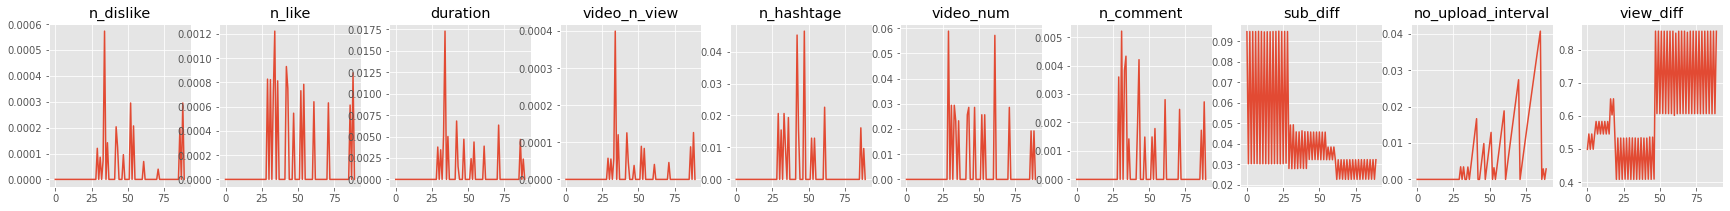

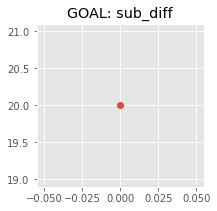

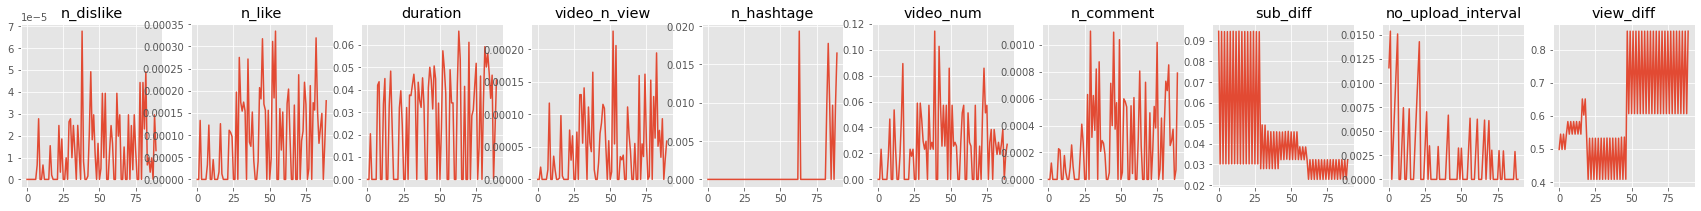

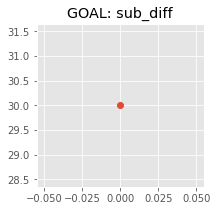

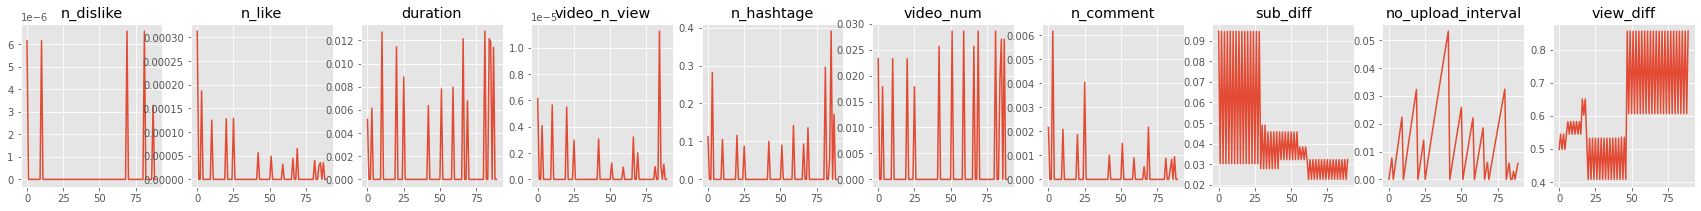

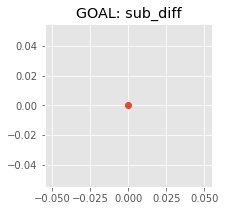

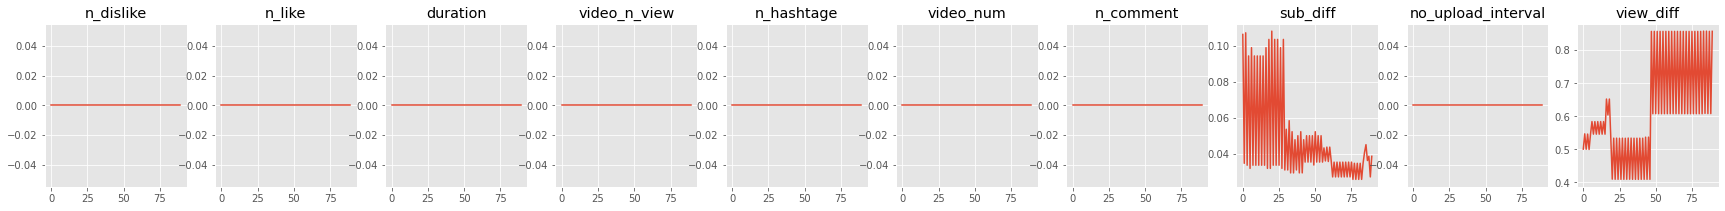

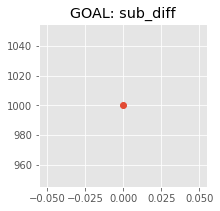

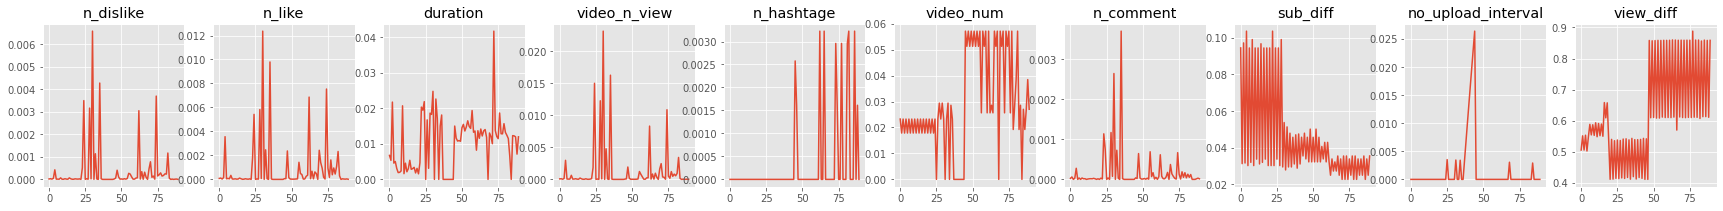

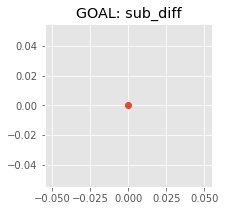

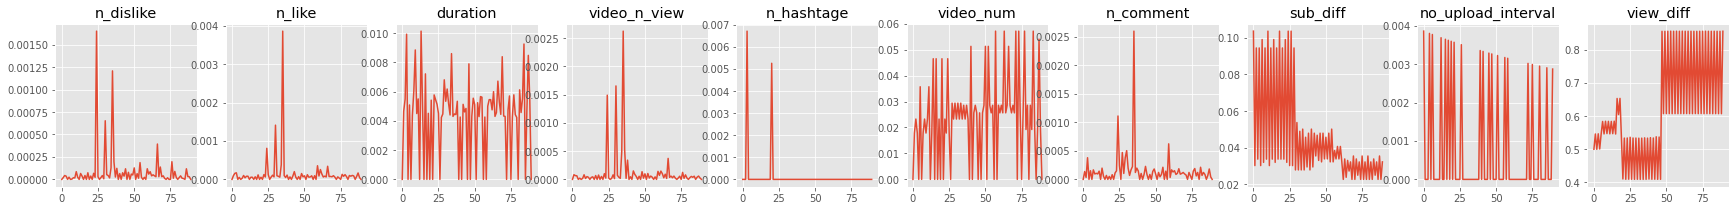

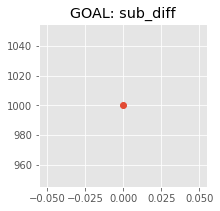

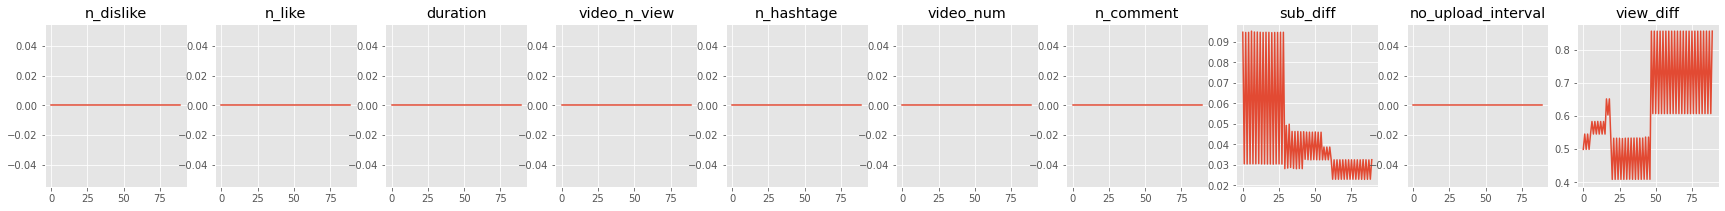

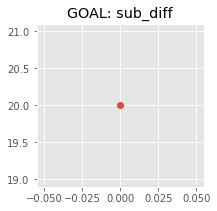

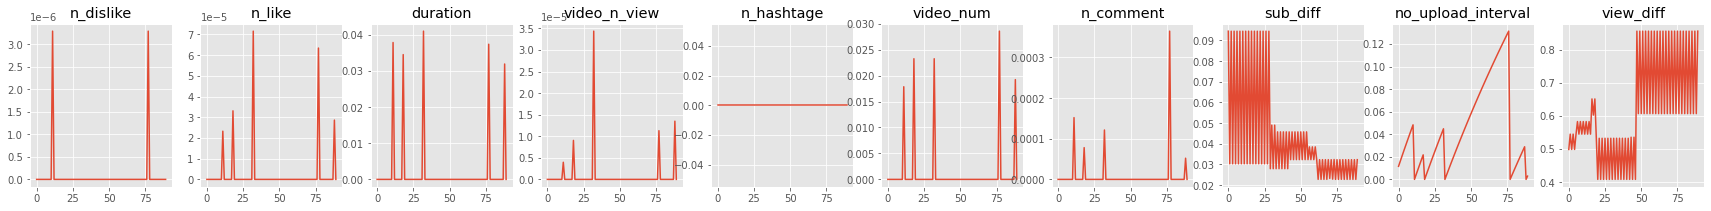

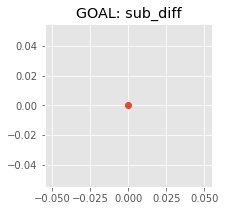

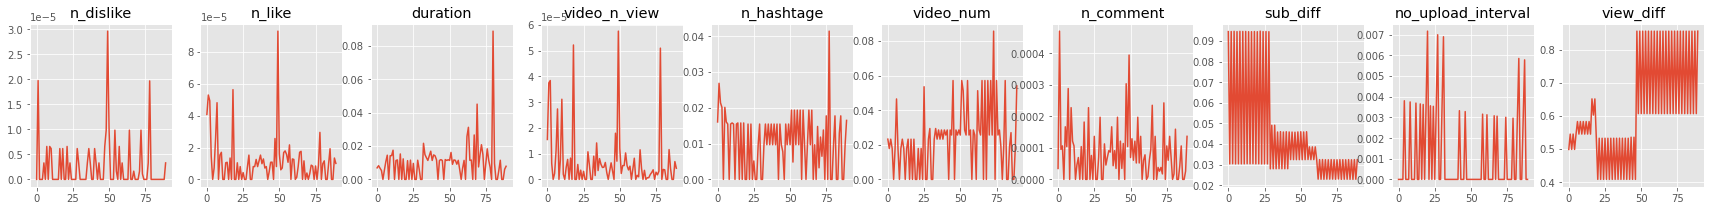

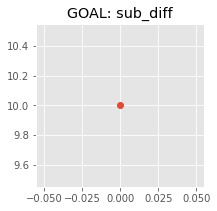

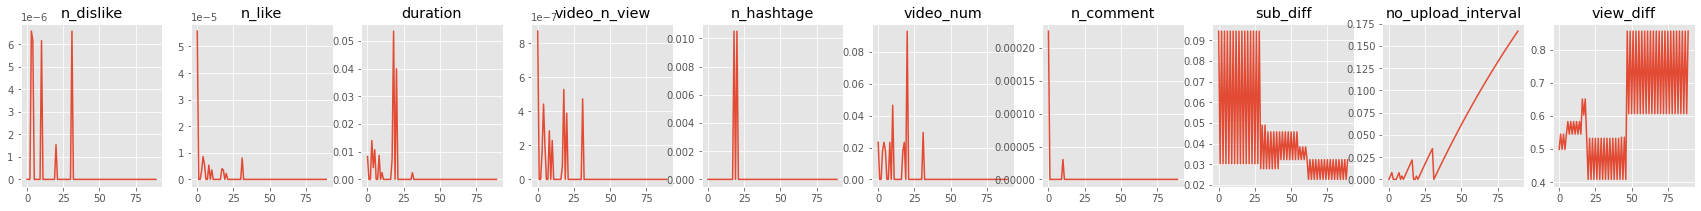

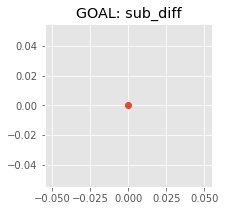

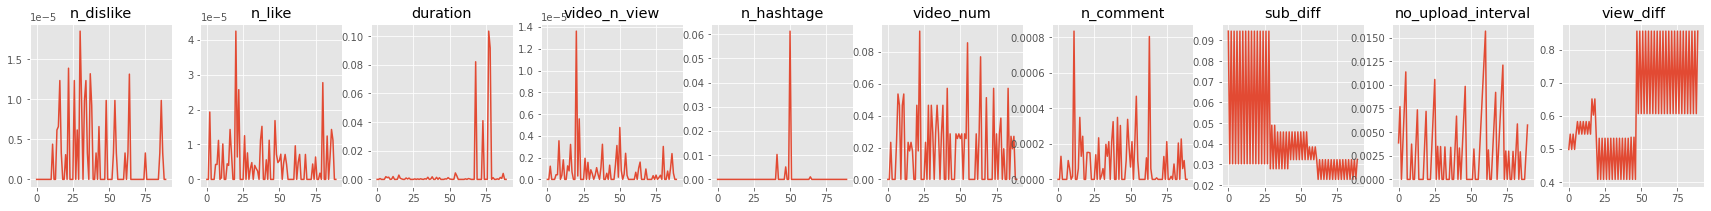

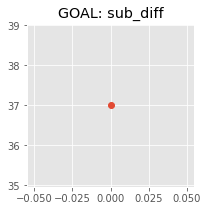

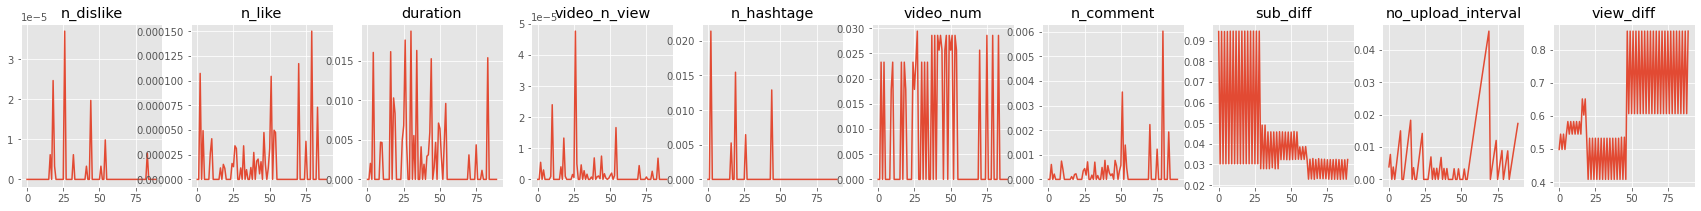

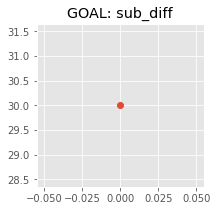

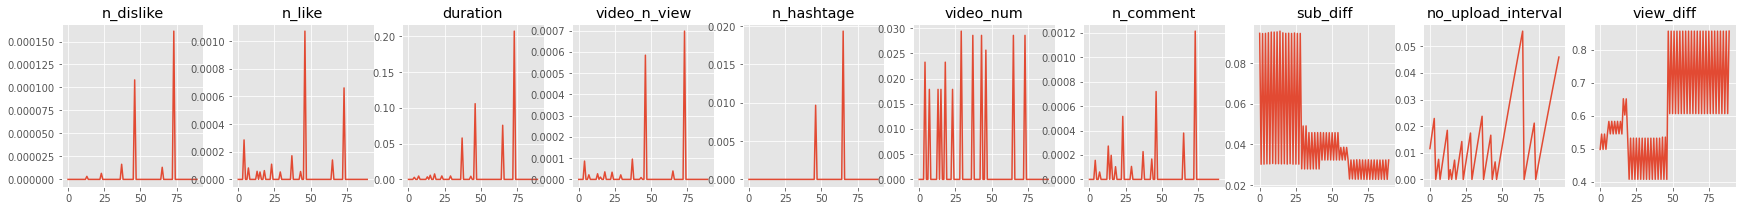

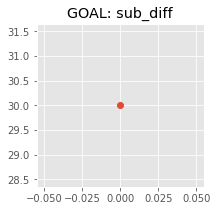

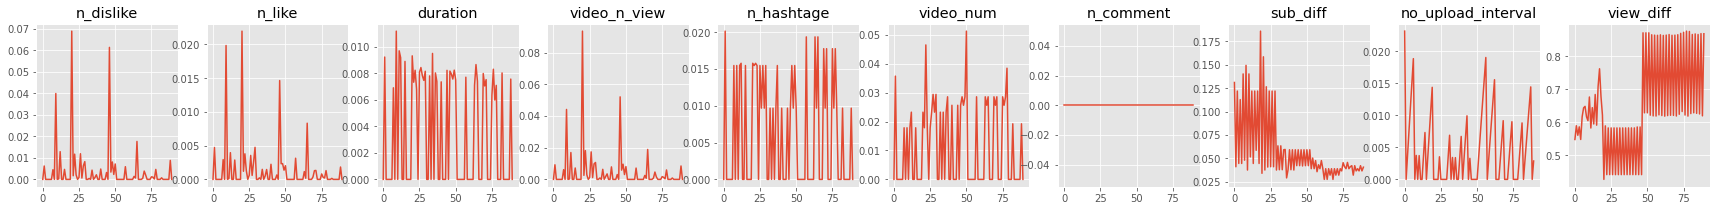

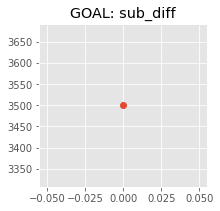

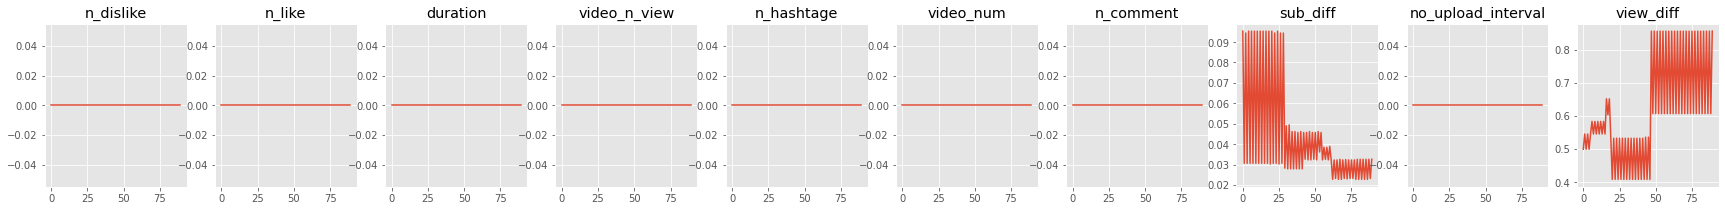

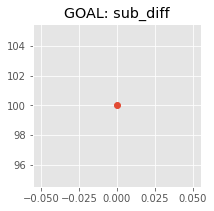

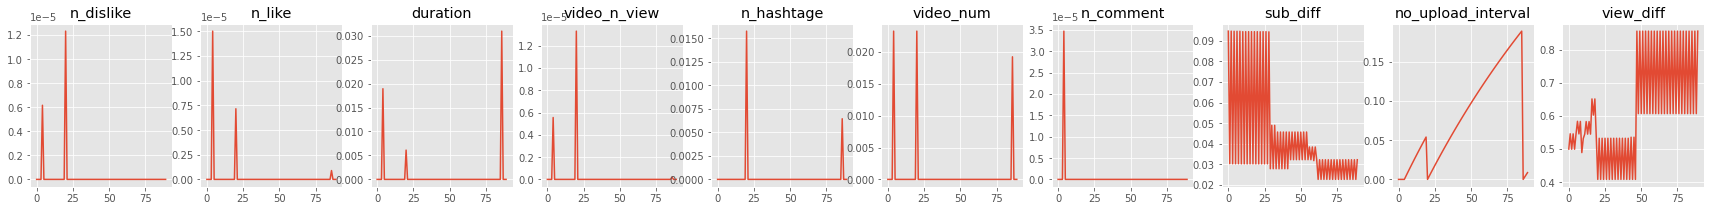

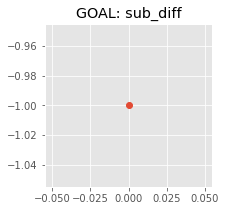

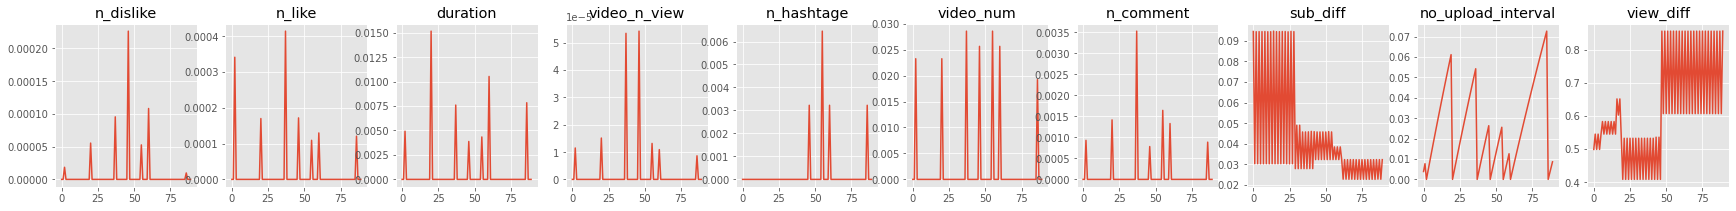

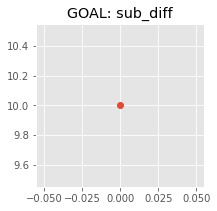

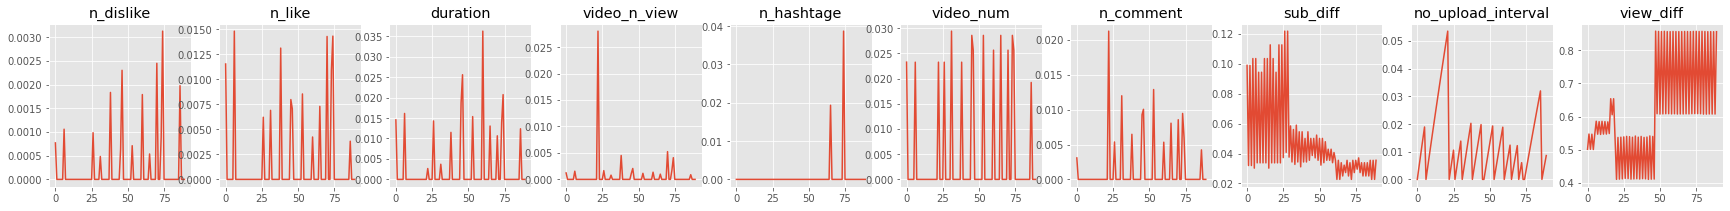

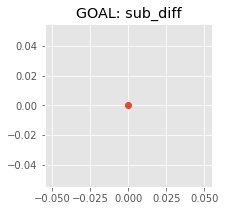

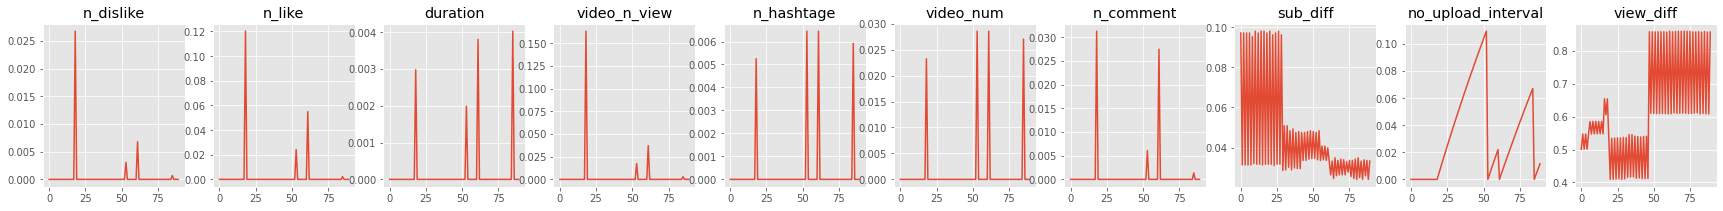

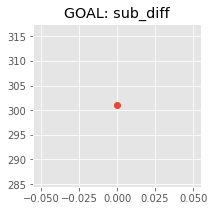

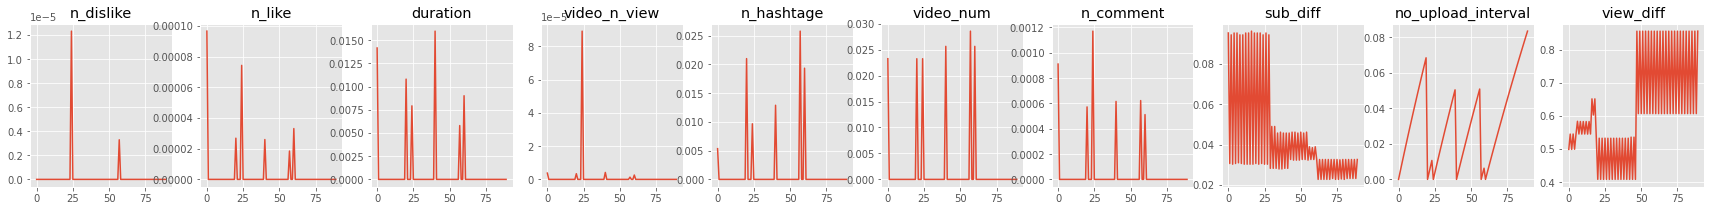

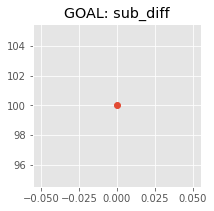

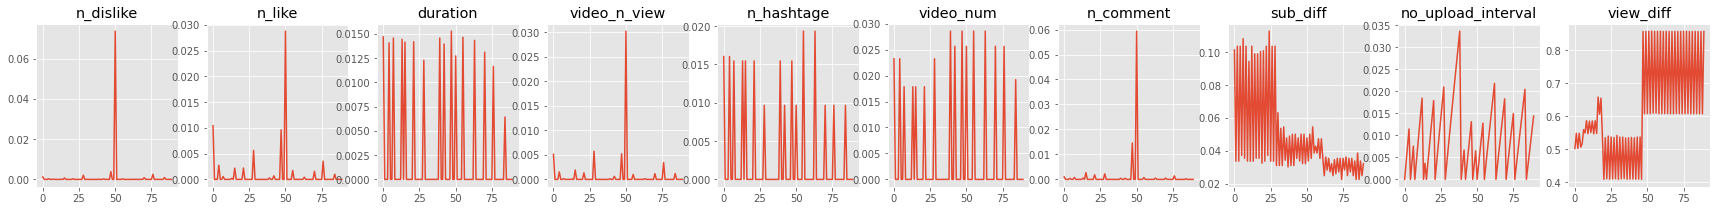

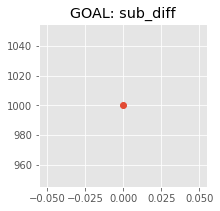

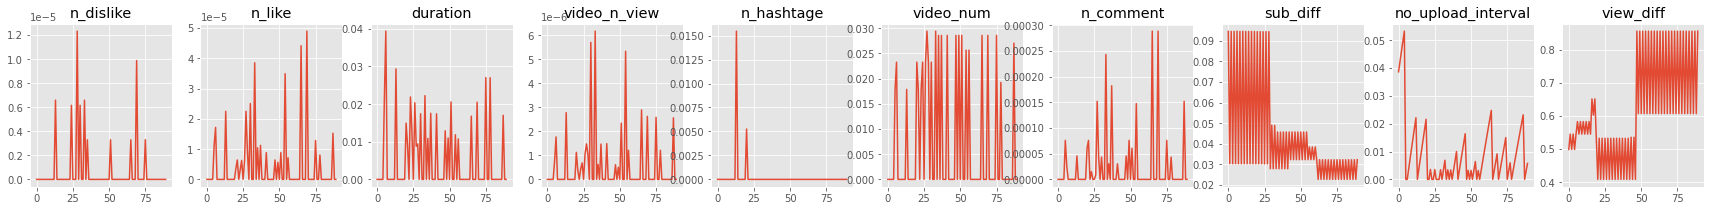

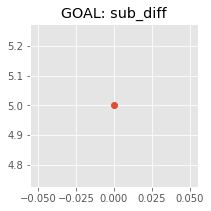

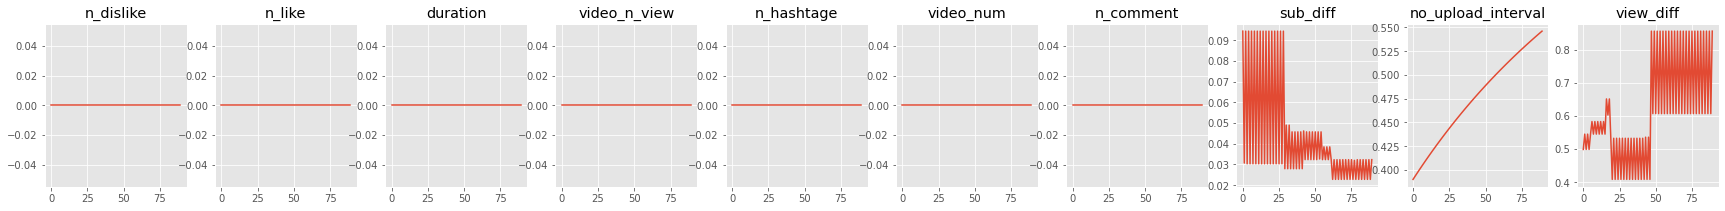

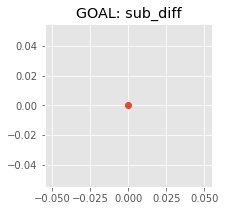

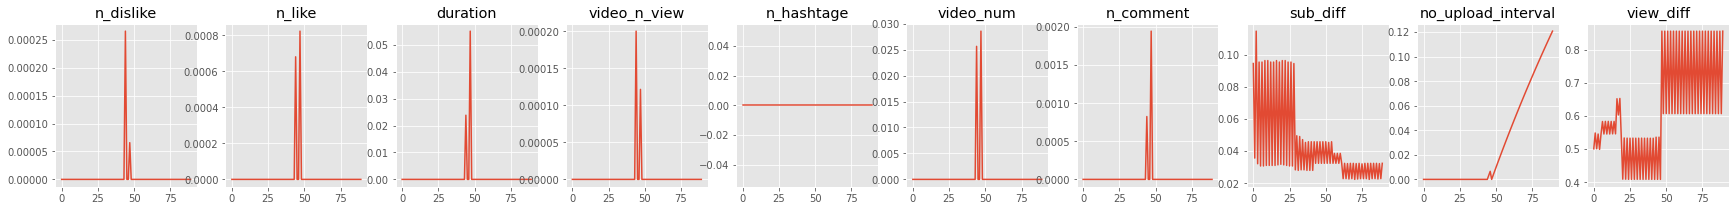

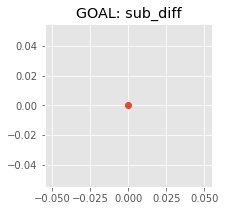

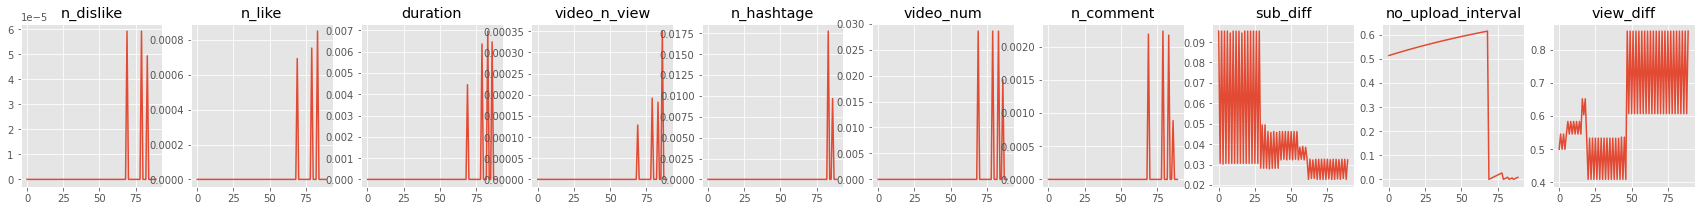

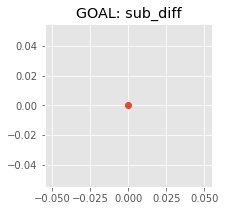

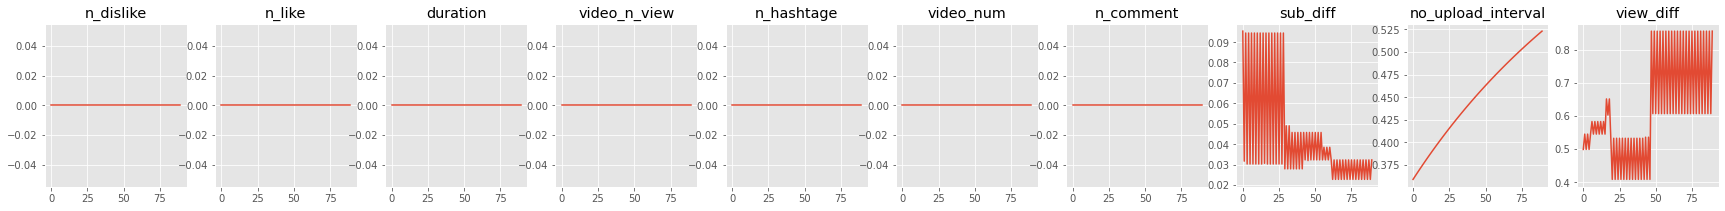

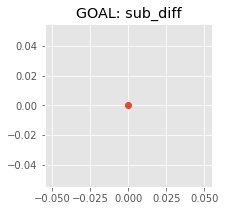

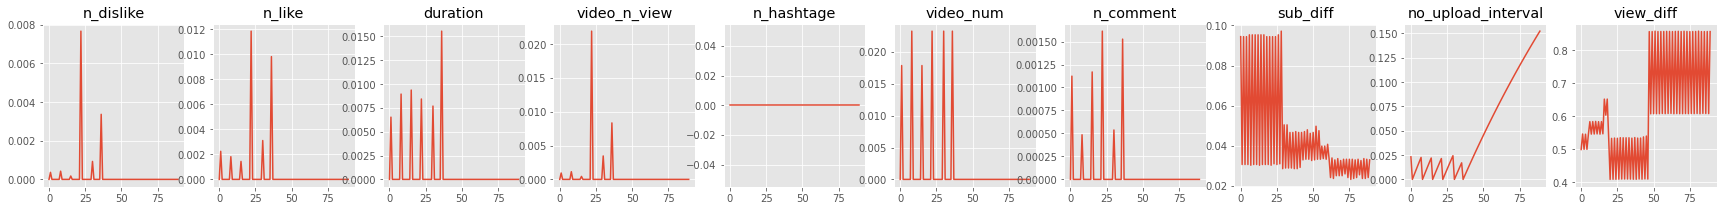

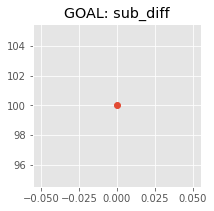

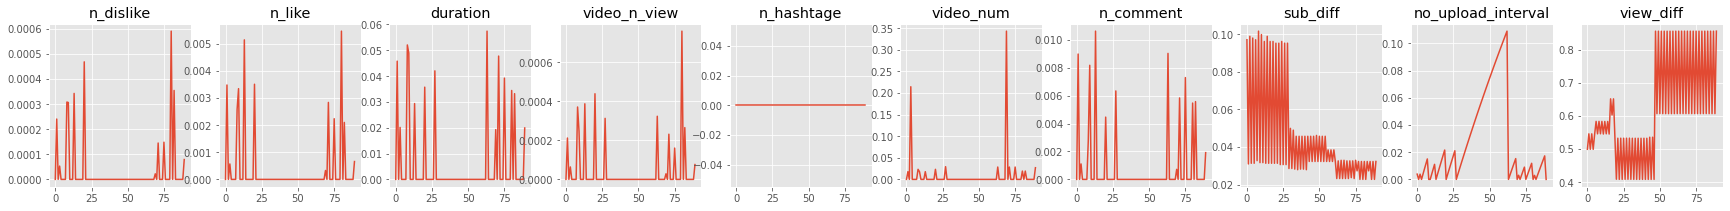

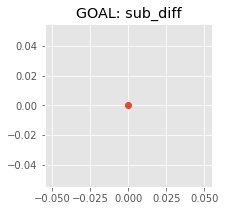

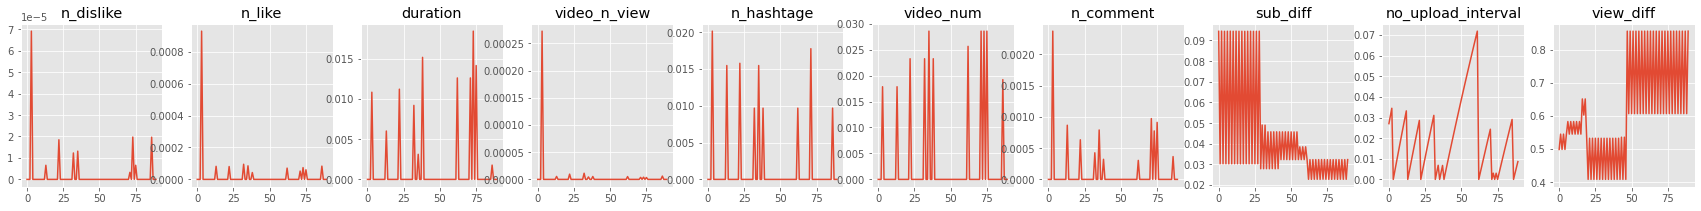

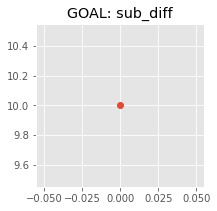

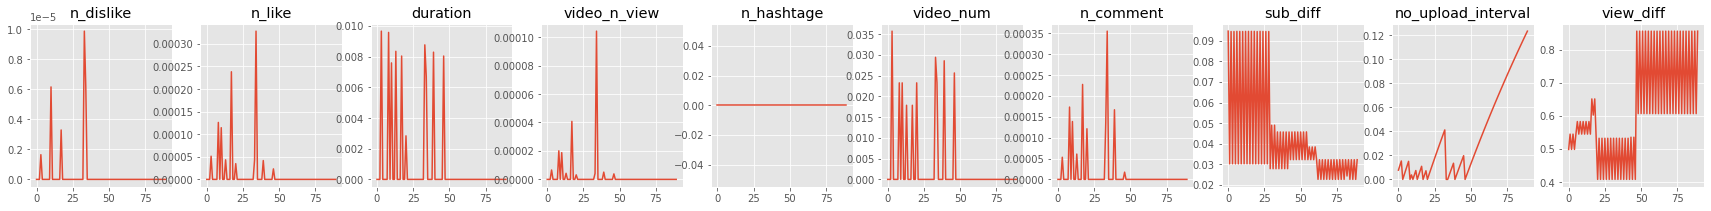

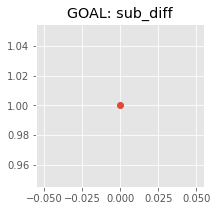

In [12]:
# 데이터 구성 살피기
import matplotlib.pyplot as plt

h = 3 # graph's height(length)

for n in range(30): # 1부터 x_train.shape[0]까지
    fig = plt.figure(figsize=(h*len(set(data_train.columns.tolist())), h))
    for i, train_var in enumerate(set(data_train.columns.tolist())):
        plt.subplot(1, len(set(data_train.columns.tolist())), i+1)
        plt.plot(x_train[train_var].iloc[n].values)
        plt.title(str(train_var))

    fig = plt.figure(figsize=(h*len(set(data_label.columns.tolist())), h))
    for i, label_var in enumerate(set(data_label.columns.tolist())):
        plt.subplot(1, len(set(data_label.columns.tolist())), i+1)
        plt.plot(y_train[label_var].iloc[n], marker='o')
        plt.title("GOAL: " + str(label_var))
        
    plt.show()

In [13]:
# 텐서 슬라이스로 변형하기
import tensorflow as tf

BATCH_SIZE = 32

train_data = tf.data.Dataset.from_tensor_slices((x_train_copy, y_train_copy))
train_data = train_data.cache().batch(BATCH_SIZE).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_val_copy, y_val_copy))
val_data = val_data.cache().batch(BATCH_SIZE).repeat()

In [14]:
# 모델 만들기
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, TimeDistributed, Conv2D, Dense, Flatten, Dropout, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam, RMSprop

output_num = 1

model = Sequential()
model.add(TimeDistributed(Dense(90, activation='softmax'),
                          input_shape=(x_train_copy.shape[-2:])))
model.add(LSTM(units=128, return_sequences=True))
model.add(Flatten())
model.add(Dense(512))
model.add(Dense(256))
model.add(Dense(256))
model.add(Dense(64))
model.add(Dense(16))
model.add(Dense(4))
model.add(Dense(output_num))

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss=['mae'],
              metrics=[tf.keras.metrics.RootMeanSquaredError()],
              optimizer=Adam(lr=0.0001)) # if gradient norm > clipnorm,
# then clipped gradient = gradient * (clipnorm / gradient norm)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 10, 90)            8190      
_________________________________________________________________
lstm (LSTM)                  (None, 10, 128)           112128    
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               655872    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                1

In [15]:
# 기록하기
import time

filename='rnn_checkpoint2.h5'

callback_list = [tf.keras.callbacks.ModelCheckpoint(filepath='Checkpoint/{}'.format(filename),
                                                    monitor='val_loss',
                                                    verbose=1,
                                                    save_best_only=True,
                                                    mode='min'),
                 tf.keras.callbacks.TensorBoard(log_dir='TensorBoard/rnn_logs2/{}'.format(time.asctime())),
                 tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10),
                 #tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                 #                                     factor=0.1,
                 #                                     min_lr=1e-4, 
                 #                                     patience=0)
                ]

EPOCHS = 100

history2 = model.fit(train_data,
                     epochs=EPOCHS,
                     steps_per_epoch=x_train.shape[0] // BATCH_SIZE, # training samples / batch size
                     validation_data=val_data,
                     validation_steps=x_test.shape[0] // BATCH_SIZE, # validation samples / batch size
                     callbacks=callback_list) 

Epoch 1/100
   1/1910 [..............................] - ETA: 0s - loss: 231.4031 - root_mean_squared_error: 693.3973WARNING:tensorflow:From /home/mskang/wheresmydog/Cancer/venv/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1909/1910 [============================>.] - ETA: 0s - loss: 296.0504 - root_mean_squared_error: 1773.9392
Epoch 00001: val_loss improved from inf to 295.32104, saving model to Checkpoint/rnn_checkpoint2.h5
1910/1910 [==============================] - 139s 73ms/step - loss: 296.0036 - root_mean_squared_error: 1773.4957 - val_loss: 295.3210 - val_root_mean_squared_error: 2059.2314
Epoch 2/100
1910/1910 [==============================] - ETA: 0s - loss: 295.8649 - root_mean_squared_error: 1773.4824
Epoch 00002: val_loss improved from 295.32104 to 294.96710, saving model to C

Epoch 44/100
1910/1910 [==============================] - ETA: 0s - loss: 206.0537 - root_mean_squared_error: 1453.4335
Epoch 00044: val_loss did not improve from 205.56709
1910/1910 [==============================] - 149s 78ms/step - loss: 206.0537 - root_mean_squared_error: 1453.4335 - val_loss: 228.8499 - val_root_mean_squared_error: 1794.3625
Epoch 45/100
1906/1910 [============================>.] - ETA: 0s - loss: 206.0551 - root_mean_squared_error: 1453.2882
Epoch 00045: val_loss improved from 205.56709 to 202.08003, saving model to Checkpoint/rnn_checkpoint2.h5
1910/1910 [==============================] - 152s 79ms/step - loss: 205.8521 - root_mean_squared_error: 1451.8428 - val_loss: 202.0800 - val_root_mean_squared_error: 1790.1023
Epoch 46/100
1910/1910 [==============================] - ETA: 0s - loss: 204.4686 - root_mean_squared_error: 1448.2251
Epoch 00046: val_loss did not improve from 202.08003
1910/1910 [==============================] - 138s 72ms/step - loss: 204.4686

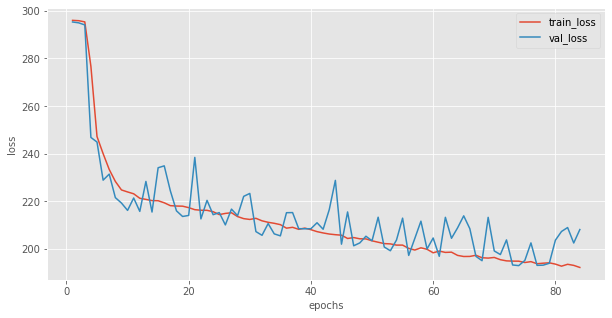

In [17]:
## 모델 성능 그래프로 나타내기
UPDATED_EPOCHS = 84 + 1

epochs = np.arange(1, UPDATED_EPOCHS)
fig, axes = plt.subplots(figsize=(10, 5))

plt.plot(epochs, history2.history['loss'], label='train_loss')
plt.plot(epochs, history2.history['val_loss'], label='val_loss')
plt.xlabel('epochs', fontdict={'size': 10})
plt.ylabel('loss', fontdict={'size': 10})
plt.legend()
plt.show()

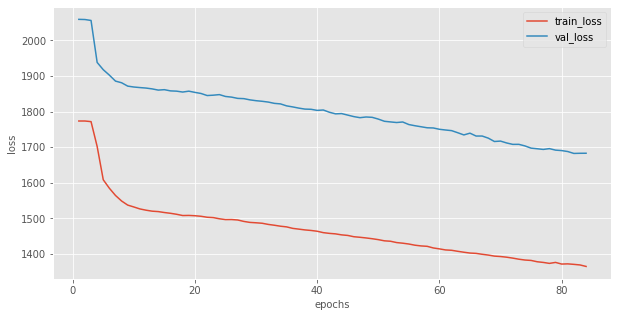

In [18]:
UPDATED_EPOCHS = 84 + 1

epochs = np.arange(1, UPDATED_EPOCHS)
fig, axes = plt.subplots(figsize=(10, 5))

plt.plot(epochs, history2.history['root_mean_squared_error'], label='train_loss')
plt.plot(epochs, history2.history['val_root_mean_squared_error'], label='val_loss')
plt.xlabel('epochs', fontdict={'size': 10})
plt.ylabel('loss', fontdict={'size': 10})
plt.legend()
plt.show()

In [50]:
######################################################################

In [5]:
# 모델 저장하고 복원하기
from tensorflow.keras.models import load_model

filename = 'rnn_model.h5'

#model.save('Model/{}'.format(filename))
res_model = load_model('Model/{}'.format(filename))
res_model.load_weights('Model/{}'.format(filename))
res_model.evaluate(x_test_copy, y_test_copy)

NameError: name 'x_test_copy' is not defined

In [21]:
# 테스트 세트로 예측하기
test_predict = model.predict(x_test_copy)

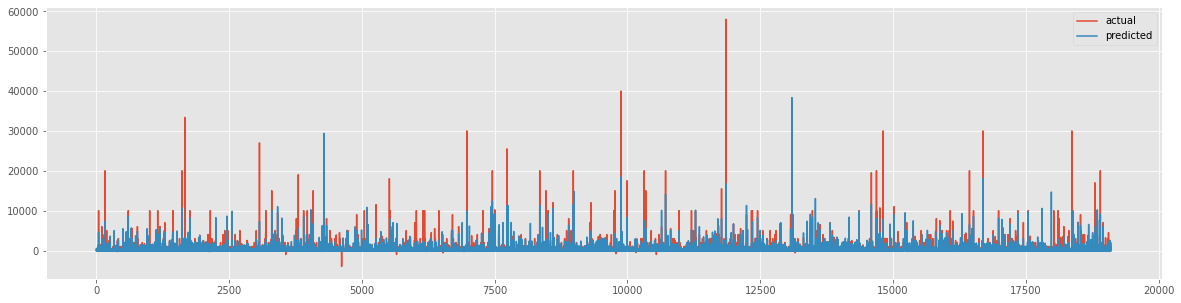

In [72]:
# 예측한 것 시각화하기 (한 개 다 합친 것)

actual = pd.DataFrame(y_test_copy[:,0,0], columns=['actual'])
pred = pd.DataFrame(test_predict[:,0], columns=['pred'])
result = pd.concat([actual, pred], axis=1)

fig, axes = plt.subplots(figsize=(20, 5))
total = [j for j in range(y_test_copy.shape[0])]
plt.plot(total, result['actual'], label='actual')
plt.plot(total, result['pred'], label='predicted')
#plt.plot(total, result['actual'], label='actual')
plt.legend()
plt.show()

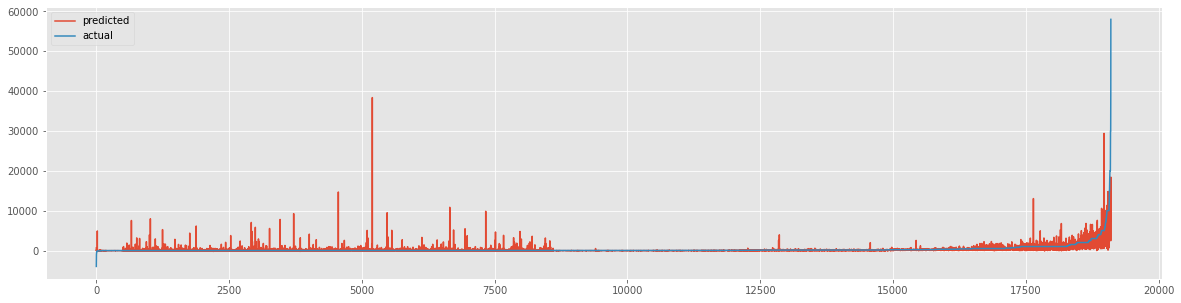

In [68]:
ord_result = result.sort_values(by=['actual'])

fig, axes = plt.subplots(figsize=(20, 5))
total = [j for j in range(ord_result.shape[0])]
plt.plot(total, ord_result['pred'], label='predicted')
plt.plot(total, ord_result['actual'], label='actual')
plt.legend()
plt.show()

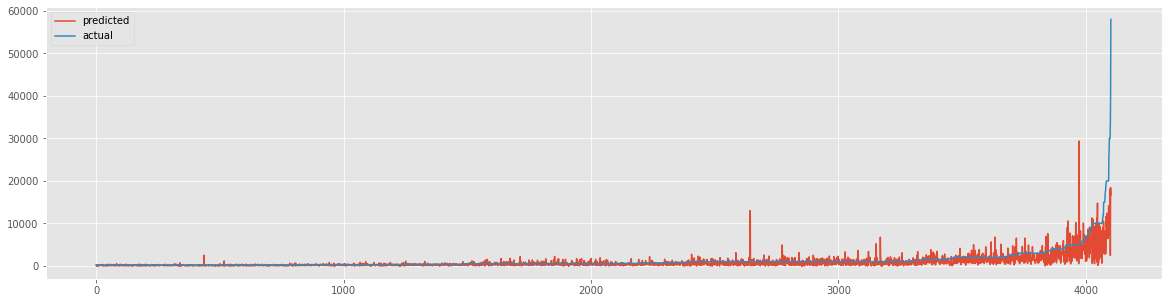

In [69]:
my_result = ord_result.iloc[15000:] # 보고 싶은 범위만

fig, axes = plt.subplots(figsize=(20, 5))
total = [j for j in range(my_result.shape[0])]
plt.plot(total, my_result['pred'], label='predicted')
plt.plot(total, my_result['actual'], label='actual')
plt.legend()
plt.show()

In [75]:
mae = 198

good_a = []
good_p = []
for i in range(result.shape[0]):
    a = result['actual'].iloc[i]
    p = result['pred'].iloc[i]

    if abs(a-p) < mae:
        good_a.append(a)
        good_p.append(p)
print(len(good_a))
print(len(go))

[0.0,
 10.0,
 0.0,
 -2.0,
 100.0,
 0.0,
 100.0,
 0.0,
 100.0,
 5.0,
 0.0,
 0.0,
 100.0,
 0.0,
 10.0,
 0.0,
 0.0,
 100.0,
 0.0,
 10.0,
 0.0,
 0.0,
 100.0,
 10.0,
 100.0,
 300.0,
 100.0,
 200.0,
 50.0,
 0.0,
 0.0,
 0.0,
 10.0,
 0.0,
 0.0,
 0.0,
 8.0,
 0.0,
 10.0,
 0.0,
 100.0,
 500.0,
 0.0,
 100.0,
 0.0,
 0.0,
 1.0,
 55.0,
 300.0,
 0.0,
 100.0,
 50.0,
 0.0,
 2.0,
 10.0,
 300.0,
 0.0,
 0.0,
 500.0,
 0.0,
 200.0,
 100.0,
 0.0,
 0.0,
 0.0,
 2.0,
 0.0,
 0.0,
 127.0,
 200.0,
 0.0,
 101.0,
 4.0,
 5.0,
 20.0,
 0.0,
 6.0,
 0.0,
 0.0,
 30.0,
 0.0,
 30.0,
 150.0,
 0.0,
 300.0,
 100.0,
 2.0,
 150.0,
 1.0,
 1.0,
 200.0,
 115.0,
 5.0,
 0.0,
 0.0,
 0.0,
 0.0,
 10.0,
 101.0,
 0.0,
 10.0,
 0.0,
 0.0,
 400.0,
 1.0,
 0.0,
 10.0,
 0.0,
 10.0,
 100.0,
 100.0,
 0.0,
 250.0,
 0.0,
 0.0,
 0.0,
 1.0,
 10.0,
 5.0,
 0.0,
 2.0,
 5.0,
 0.0,
 0.0,
 0.0,
 100.0,
 0.0,
 10.0,
 400.0,
 0.0,
 0.0,
 100.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 100.0,
 200.0,
 200.0,
 50.0,
 0.0,
 500.0,
 10.0,
 0.0,
 5.0,
 200.0,
 100.0,
 0.0,
 0.0,

/home/mskang/wheresmydog/Cancer/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


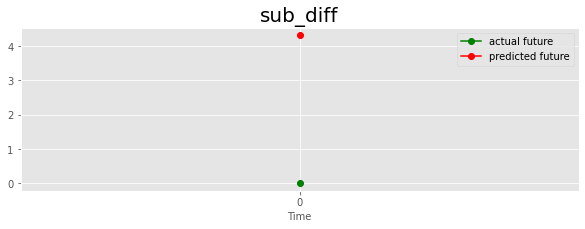

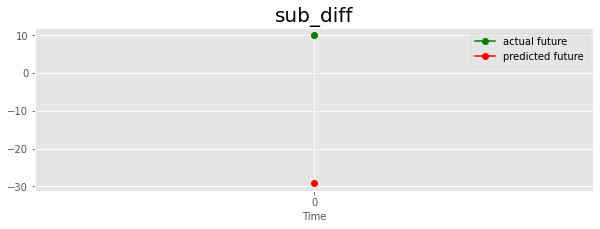

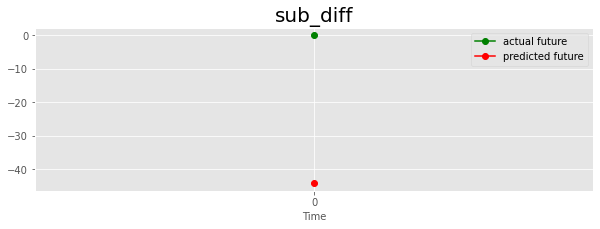

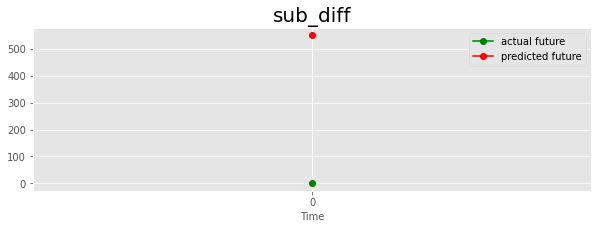

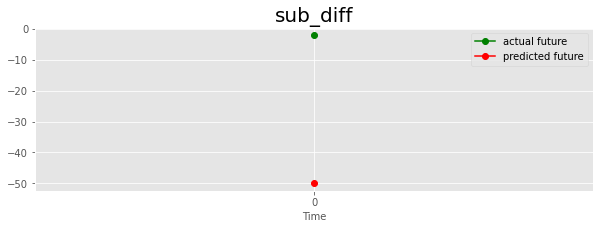

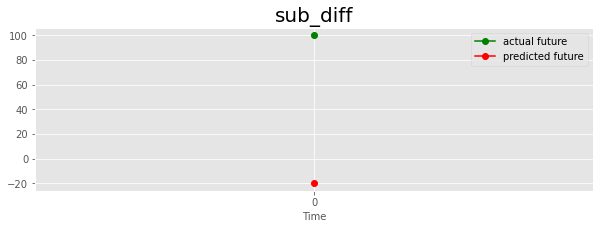

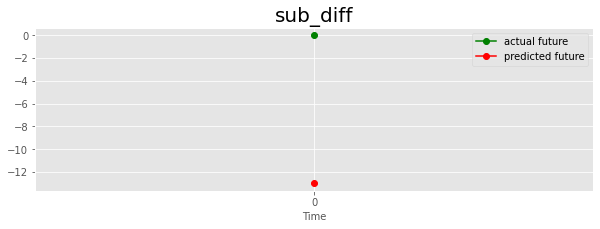

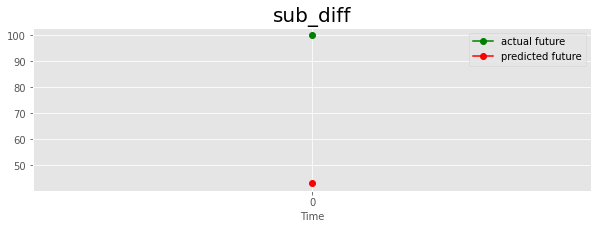

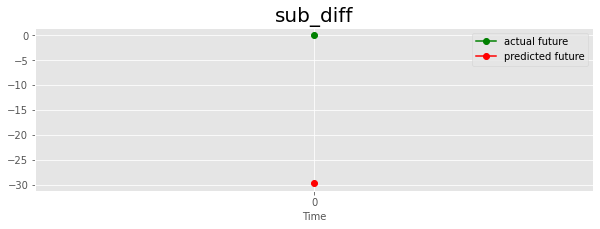

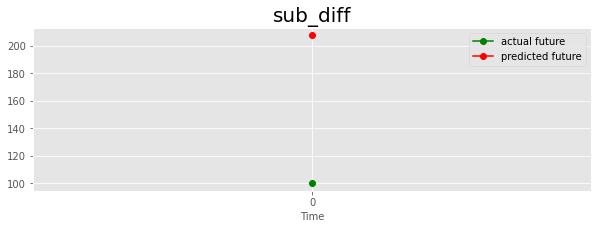

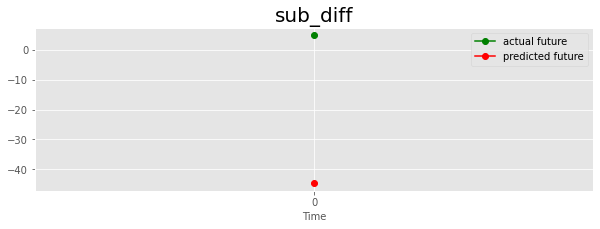

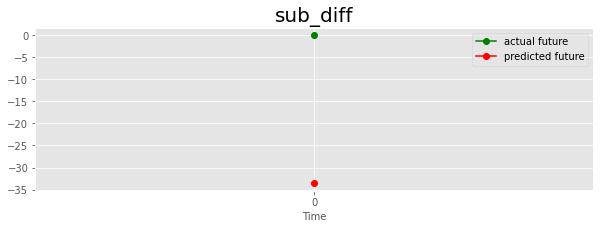

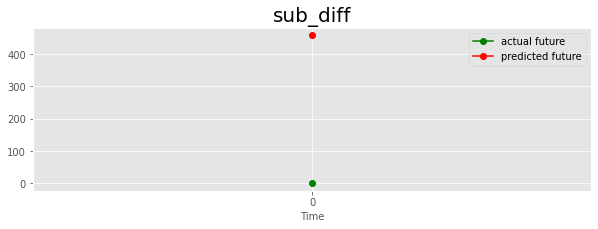

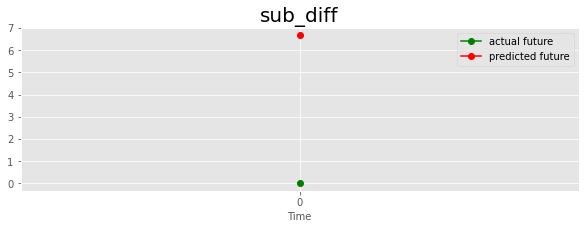

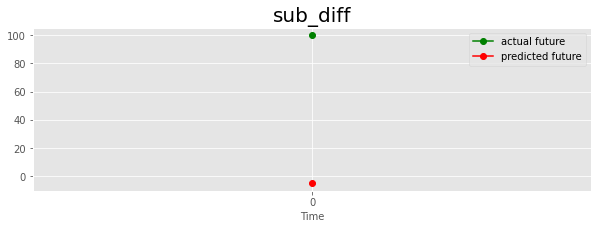

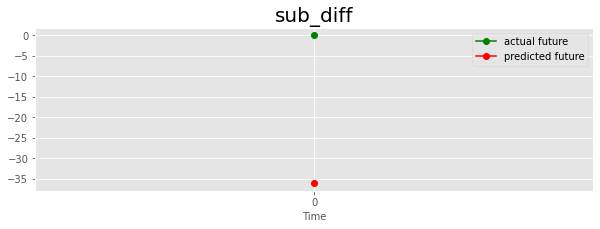

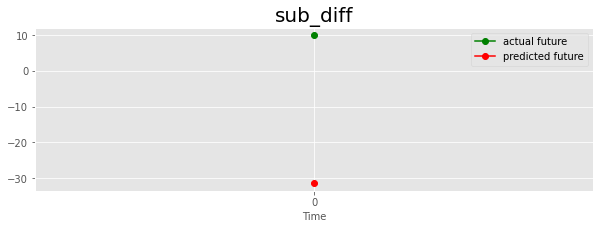

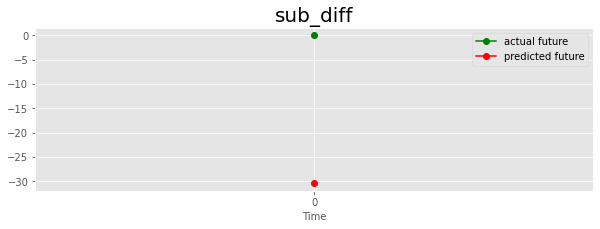

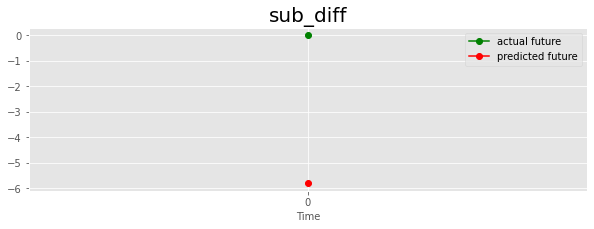

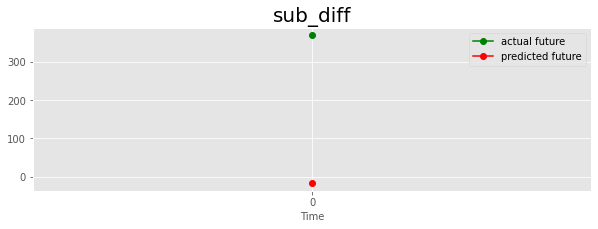

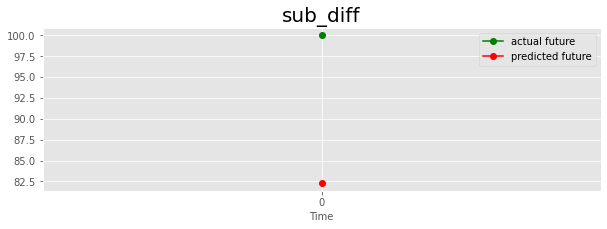

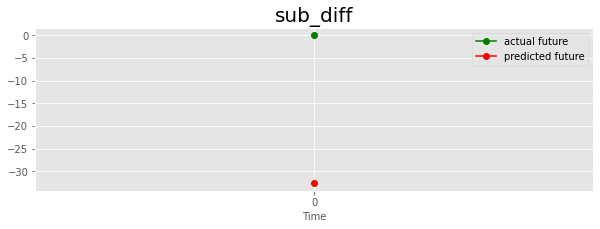

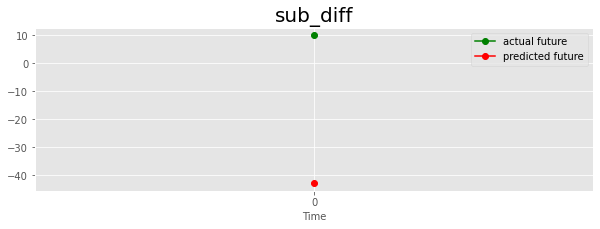

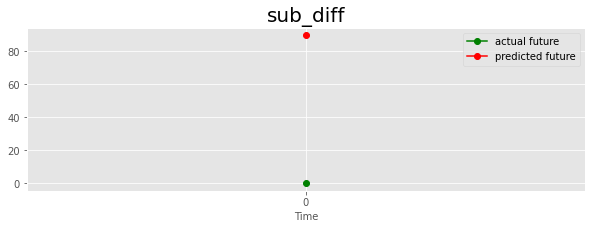

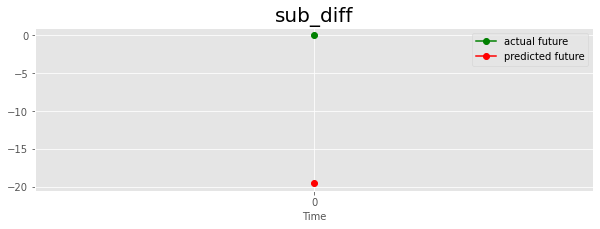

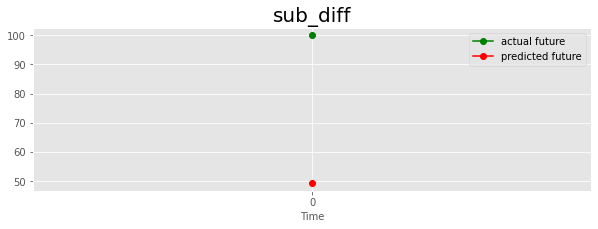

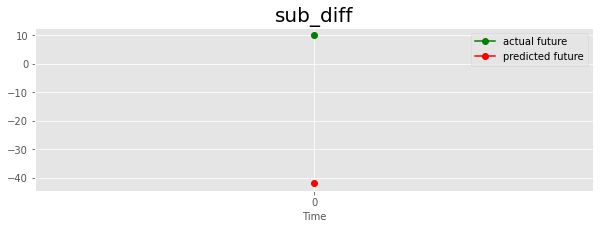

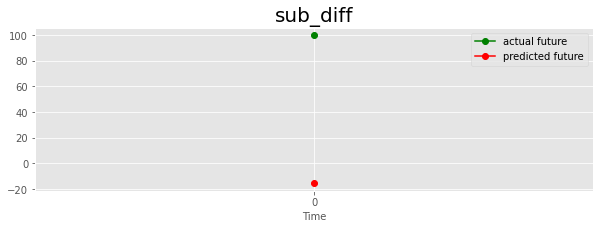

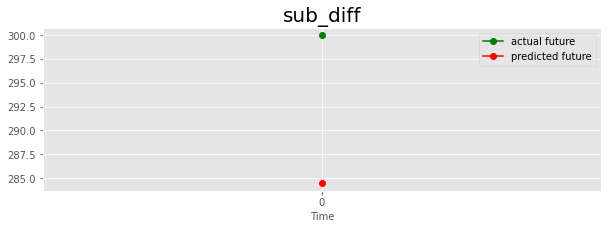

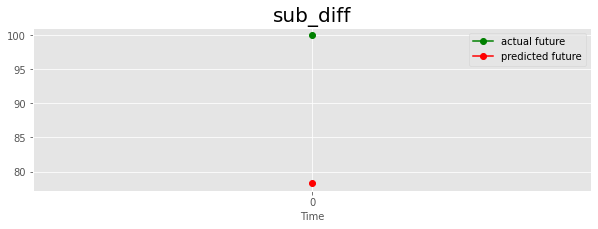

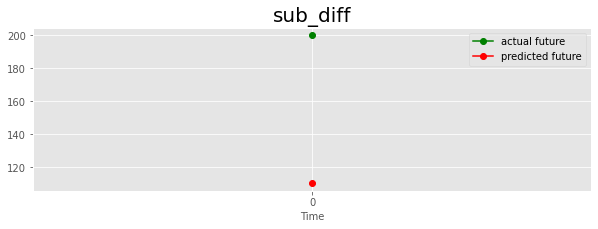

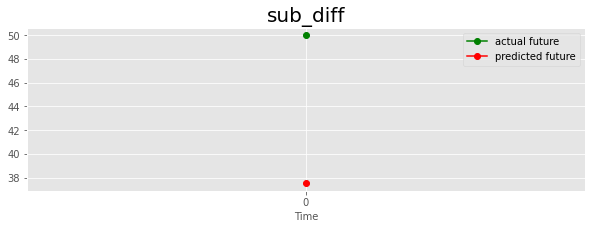

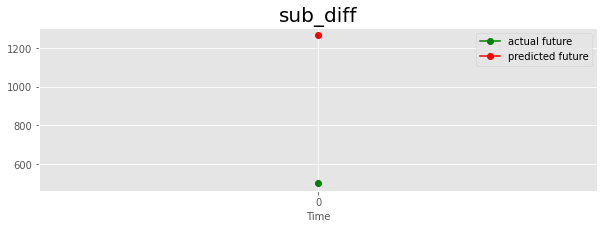

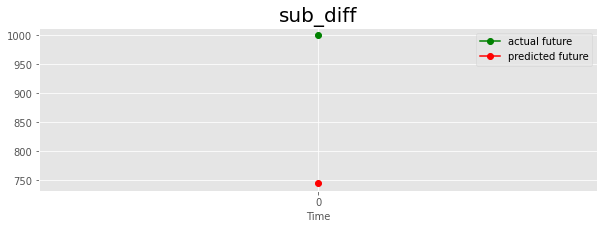

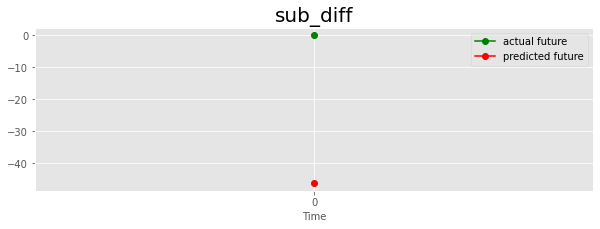

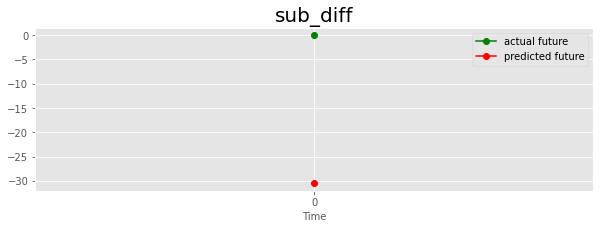

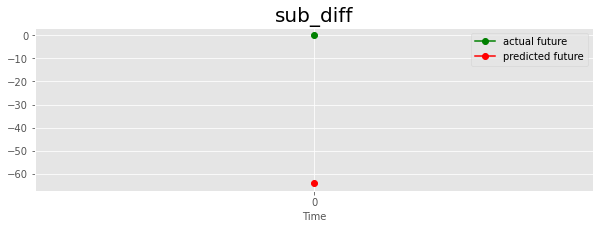

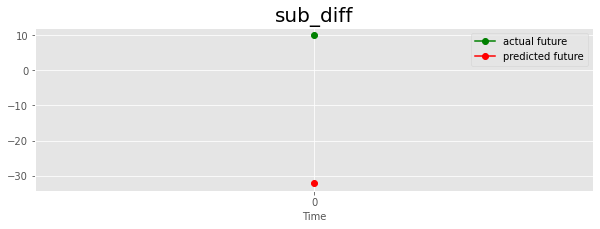

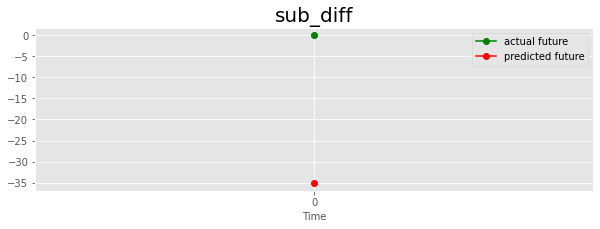

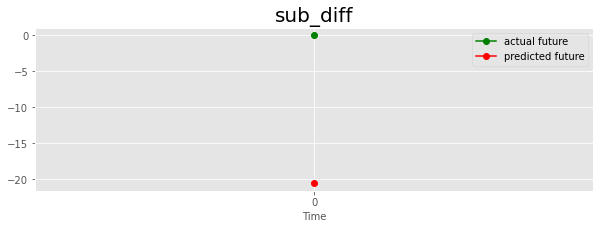

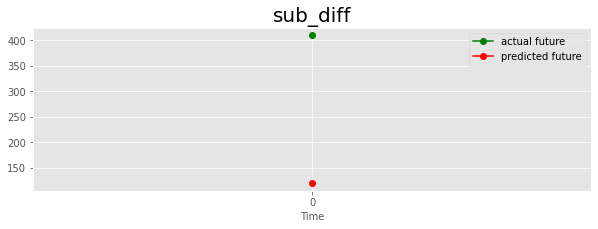

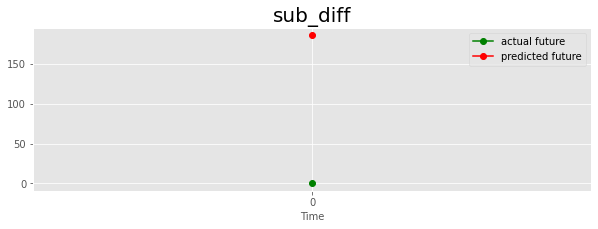

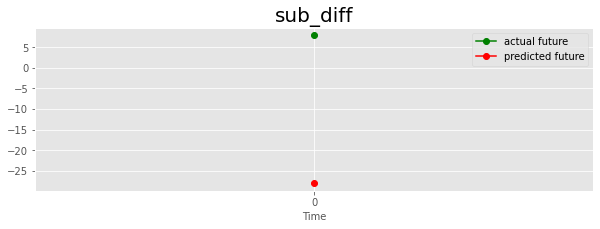

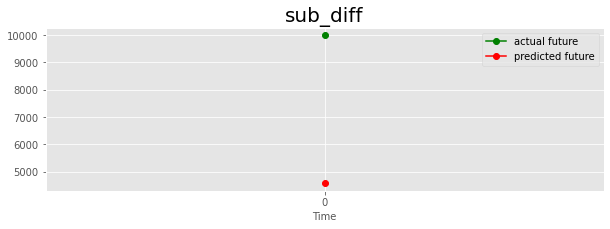

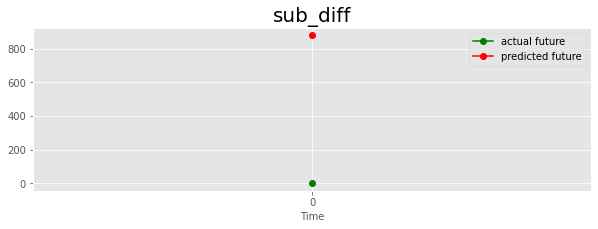

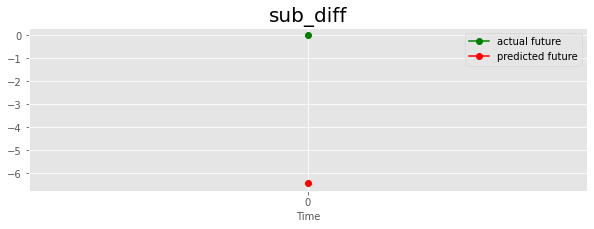

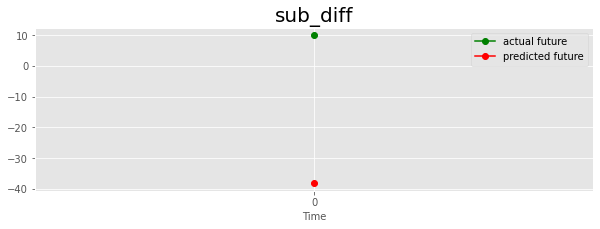

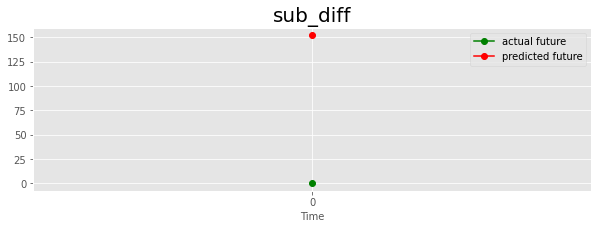

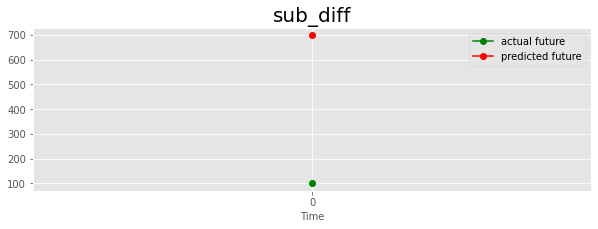

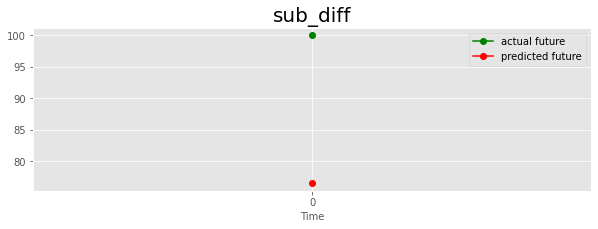

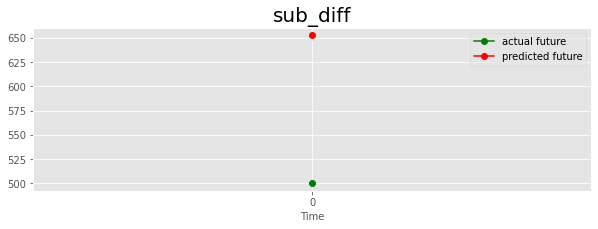

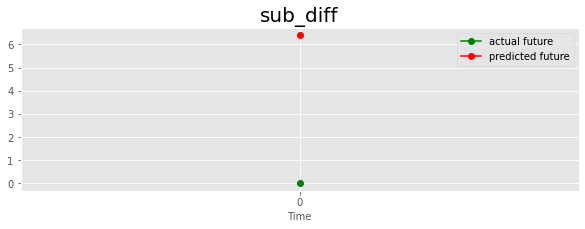

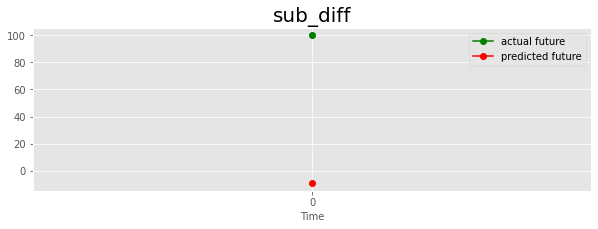

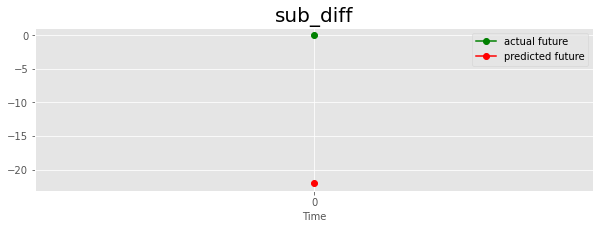

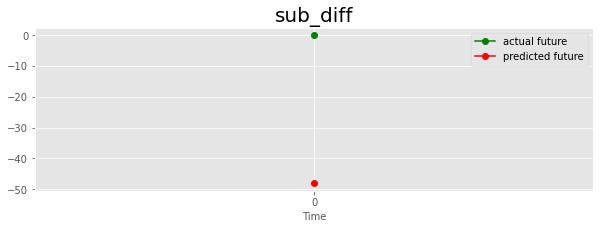

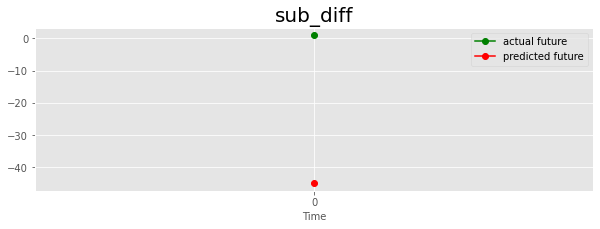

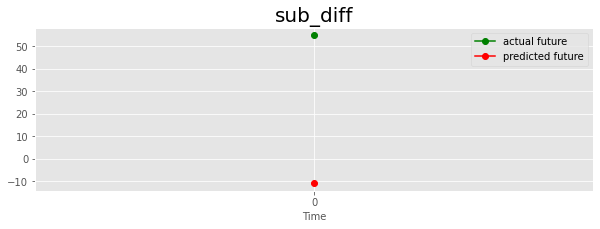

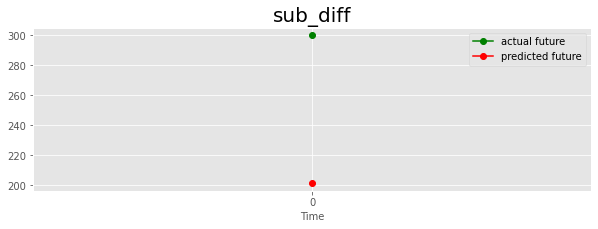

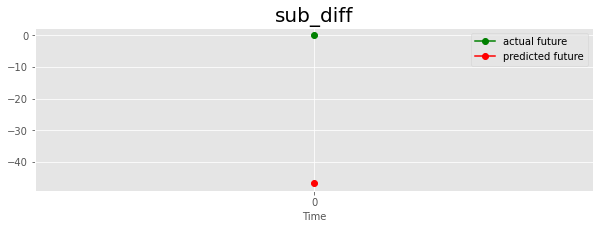

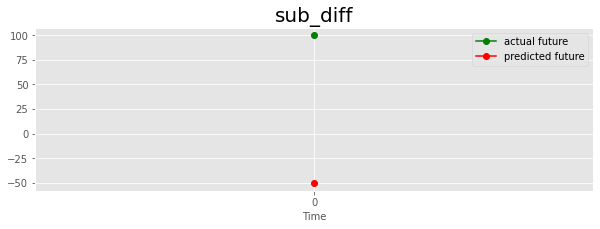

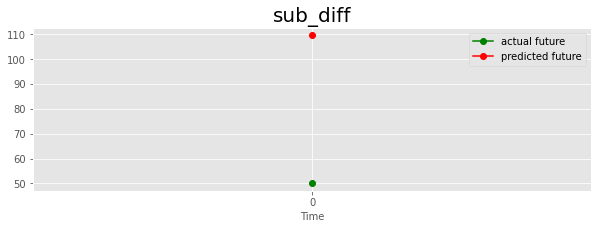

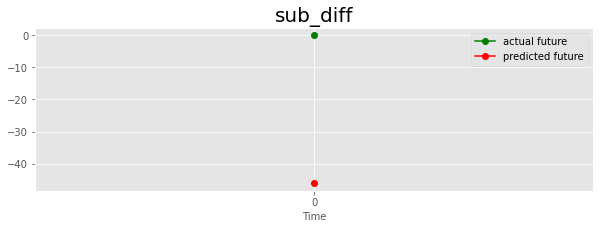

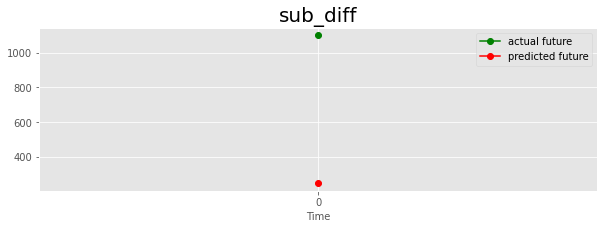

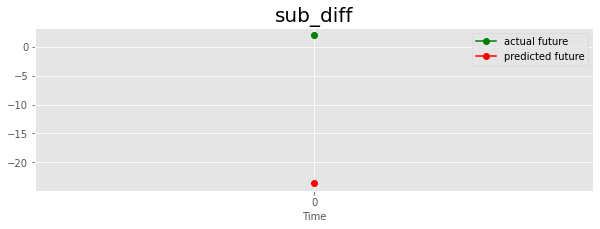

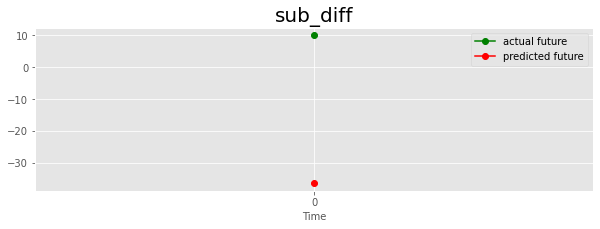

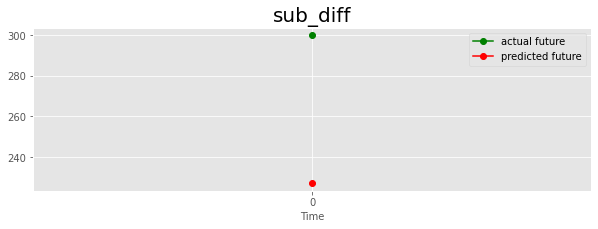

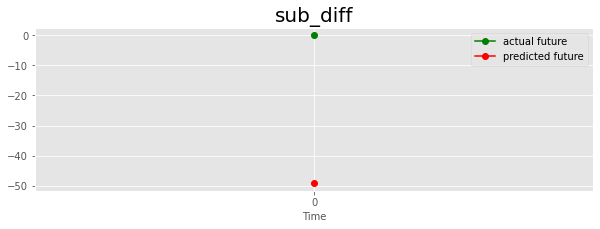

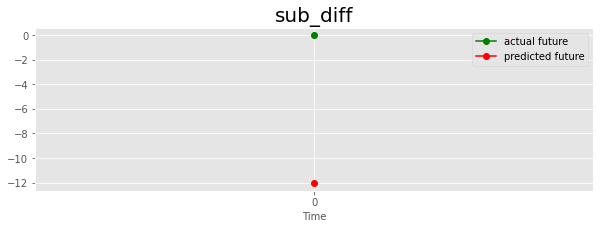

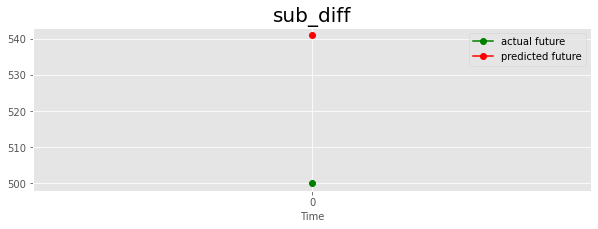

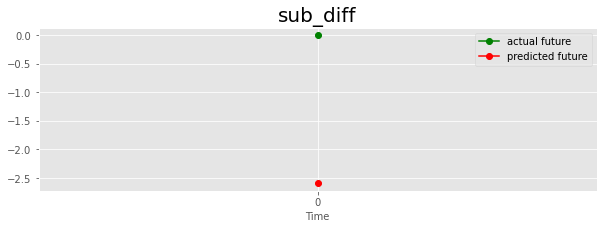

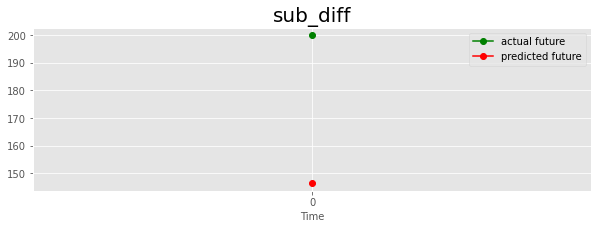

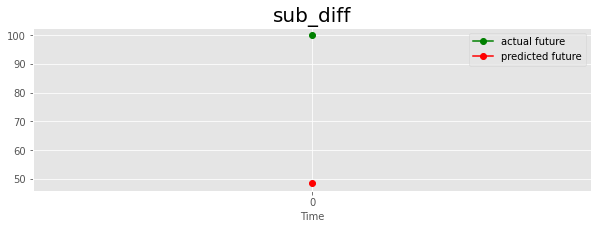

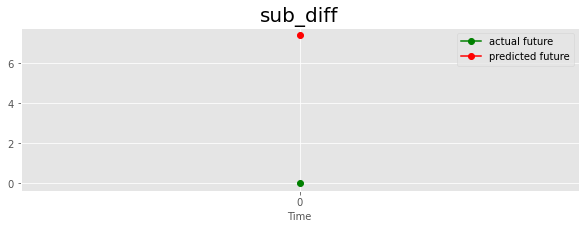

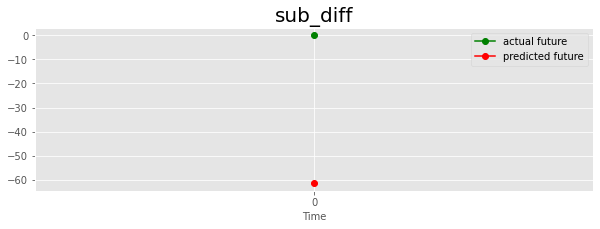

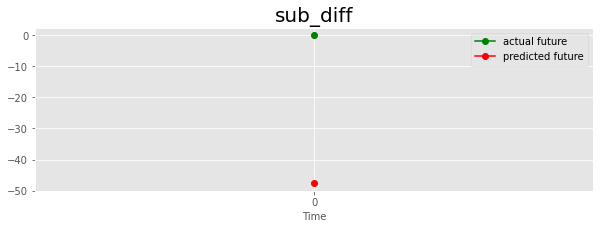

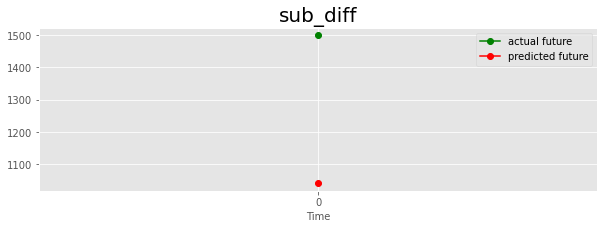

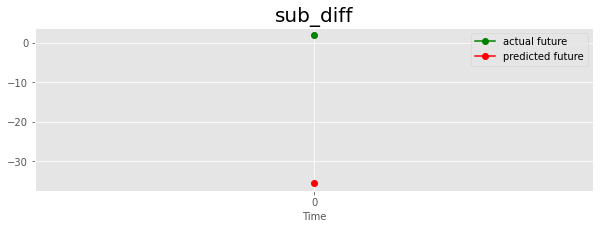

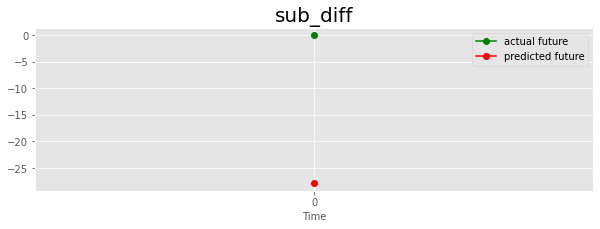

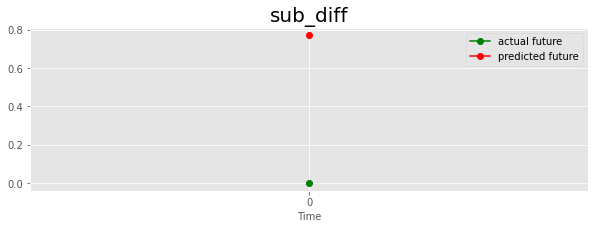

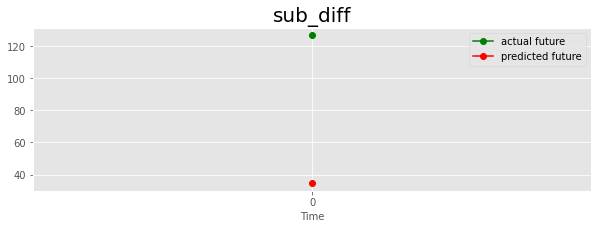

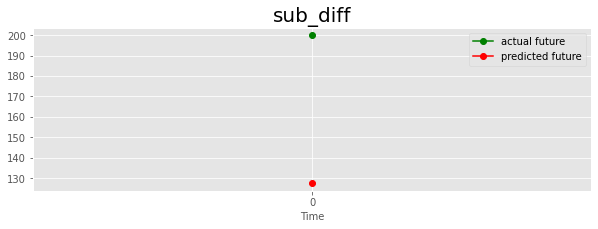

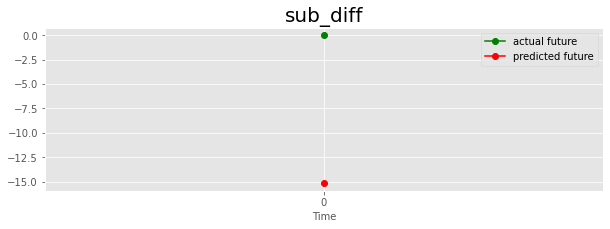

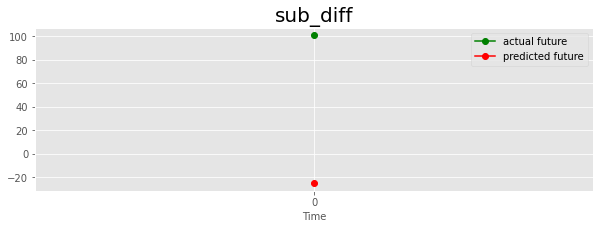

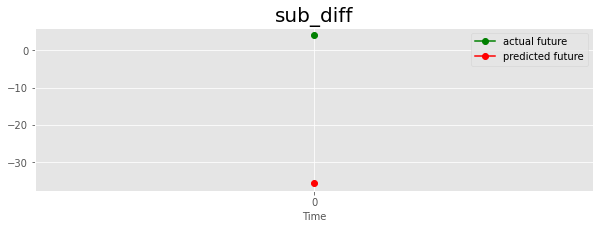

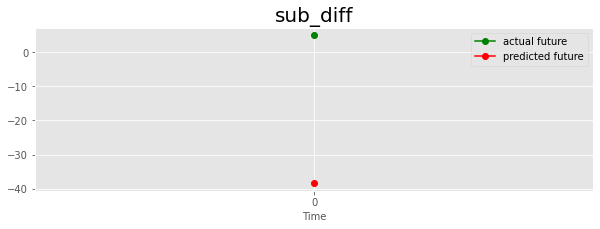

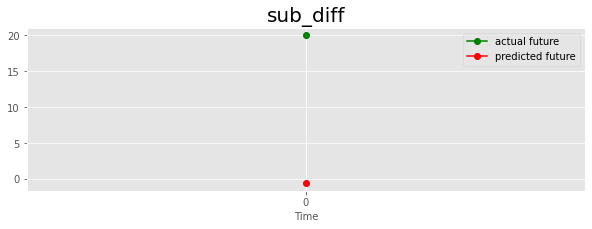

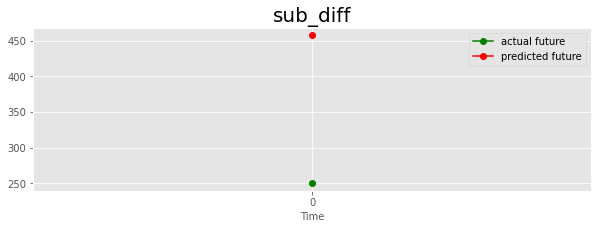

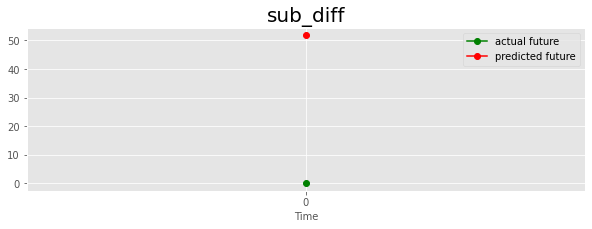

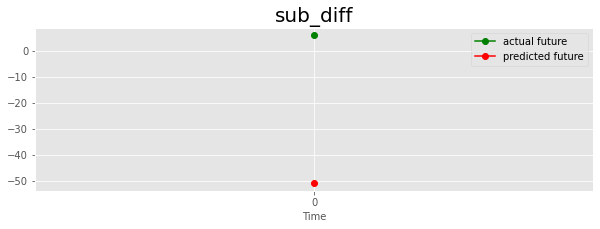

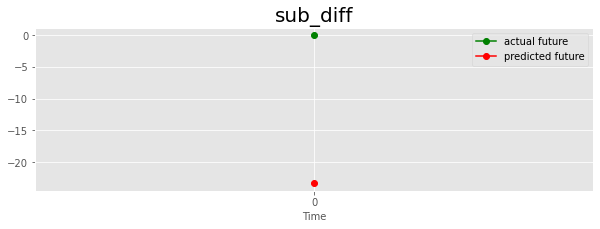

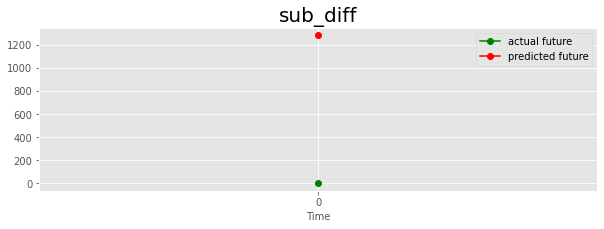

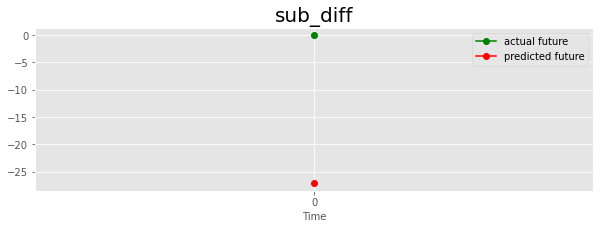

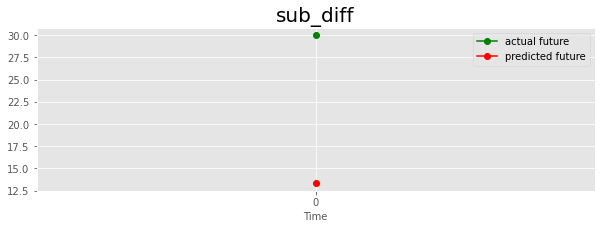

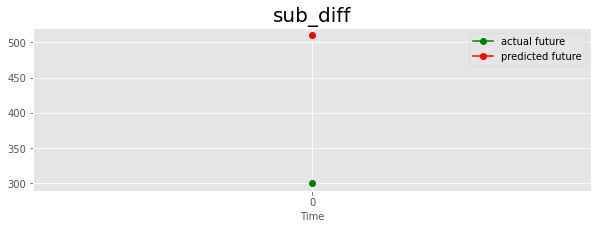

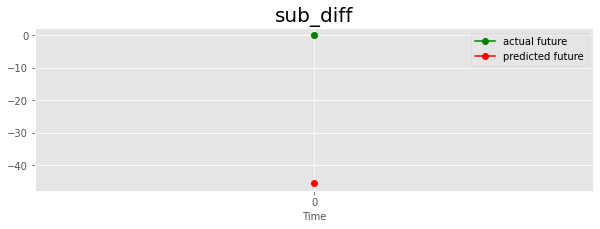

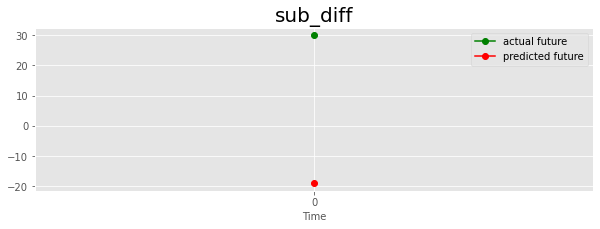

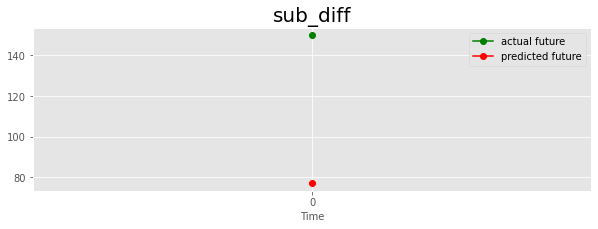

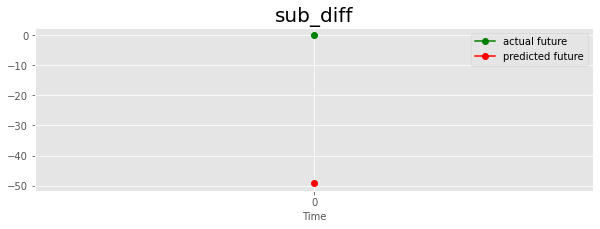

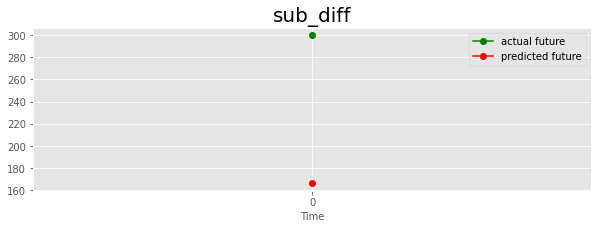

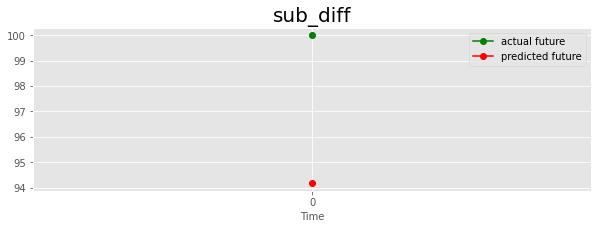

In [52]:
# 예측한 것 시각화하기 (추이)

#n = x_test.shape[0]
n = 100 # 몇 개만
past_num = 0
future_num = 1
w = past_num+future_num

for i in range(n):
    dates = [j for j in range(w)]
    fig, axes = plt.subplots(figsize=(10, 3))
    
    for j, label_var in enumerate(set(y_test.columns.tolist())):
        plt.subplot(1, len(set(y_test.columns.tolist())), j+1)
        #plt.plot(dates[:past_num], x_test_copy[i][j*past_num:(j+1)*past_num], 'k', label='past')
        
        plt.plot(dates[past_num:], y_test_copy[i][j*future_num:(j+1)*future_num], 'g', marker='o', label='actual future') 
        plt.plot(dates[past_num:], test_predict[i][j*future_num:(j+1)*future_num], 'r', marker='o', label='predicted future') # ?
        #plt.plot(dates[past_num:], y_test_copy[i], 'g', marker='o', label='actual future') 
        #plt.plot(dates[past_num:], test_predict[i], 'r', marker='o', label='predicted future') # ?
        
        plt.title(label_var, fontdict={'size': 20})
        plt.xlabel('Time', fontdict={'size': 10})
        plt.xticks(np.arange(0, len(dates), 30))
        plt.legend()
